# Methods to identify antigenic loci from sequence data
In this notebook, I'm going to test a variety of methods for identifying antigenic loci from longitudinal sequence data, either wgs or AMA1.

For AMA1 sequencing, I'll have 50 unique haplos and use presence of those to identify unique infections.
For wgs sequencing, I'll call new infections whenever a new haplo in any location shows up.
__________

For each infection, I'll plan to test the following outcomes:
- parasite density
- delta parasite density
- symptomatic infection
- time between symptomatic infections

Against the following predictors:
- Time since antigen
- Number of exposures of antigen
- proportion of antigens in infection seen before
- prop of antigens in population seen
- Seen before
_______________
For each clone, I'll plan to test the following outcomes:
- parasite density
- delta parasite density
- relative parasite density
- delta relative parasite density

Against the following predictors:
- time since antigen
- number of exposures to antigen
- seen before
__________
Separately, I'll also consider the following analyses:
- time until allele seen
- haplotype diversity
- first to second


In [2]:
os.chdir('/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/') 

In [3]:
def get_visits(malaria,period,y):
    '''
    Returns passive & active visit dates in a list.
    '''
    start = np.random.randint(1,period)
    if len(malaria) and start > malaria[0]:
        start = malaria[0]
    active = set(range(start,y*365,period))
    visits = list(active.union(set(malaria)))
    visits.sort()
    return visits

def grab_visits(cohort_malaria,period,y):
    cohort_visits = {person:get_visits(cohort_malaria[person],period,y) for person in cohort_malaria.keys()}
    return cohort_visits

def plot_scatter(x,y,xlab,ylab,path=None,alpha=0.5,corr=True):
    fig, ax = plt.subplots()
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.scatter(x,y,alpha=alpha)

    if corr == True:
        b, a = np.polyfit(x, y, deg=1)
        xseq = np.linspace(min(x), max(x), num=100)
        ax.plot(xseq, a + b * xseq, color="k", lw=1)
        m = np.corrcoef(x, y)
        ax.text(0.05,0.9,f"R: {m[0,1]:.2f}",transform = ax.transAxes)
    if path:
        fig.savefig(path,dpi=300)

def update_clone(clones, Type, d,locus, timer, counter,person,allparasites,date,abs_pdens):
    for clone in clones:
        d['person'].append(person)
        d['clone'].append(clone)
        d['lociType'].append(Type)
        cPdens = allparasites[person,locus,clone,date]
        d['pdens'].append(cPdens)
        d['relativeFreq'].append(cPdens/abs_pdens)
        d['age'].append(date)
        time = timer[clone]
        if time ==0:
            time = None
        d['timeSinceAllele'].append(time)
        d['nAllele'].append(counter[clone])
    return d

In [4]:
def infer_infect_AMA1(all_parasites,all_malaria,all_visits,ama1,testLocus,ctrlLocus,thresh=10):
    n_people,nLoci,nAlleles,days = all_parasites.shape
    testPop = len(np.where(np.sum(all_parasites[:,testLocus,:,:],axis=(0,2))>0,)[0])
    ctrlPop = len(np.where(np.sum(all_parasites[:,ctrlLocus,:,:],axis=(0,2))>0,)[0])
    
    idict = {
        'person':[],
        'pdens':[],
        'symptomatic':[],
        'infectNumber':[],
        'COIinfection':[],
        'clonesBefore':[],
        'malariaNumber':[],
        'age':[],
        'timeSince':[],
        'timeSinceSymp':[],
        'timeSinceTest':[],
        'timeSinceCtrl':[],
        'nTest':[],
        'nCtrl':[],
        'propTestSeen':[],
        'propCtrlSeen':[],
        'propTestPop':[],
        'propCtrlPop':[]
    }
    
    cdict = {
        'person':[],
        'clone':[],
        'lociType':[],
        'pdens':[],
        'relativeFreq':[],
        'age':[],
        'timeSinceAllele':[],
        'nAllele':[]
    }
    
    for person in range(n_people):
        current = set()
        currentTest = set()
        currentControl = set()
        clones = 0
        infects = 0
        malaria = 0
        timeInfect = None
        daySymp = None
        timeAllele = np.zeros(testPop,dtype=int) 
        nAllele = np.zeros(testPop,dtype=int)
        timeControl = np.zeros(ctrlPop,dtype=int) 
        nControl = np.zeros(ctrlPop,dtype=int) 
        for date in all_visits[person]:
            abs_pdens = np.sum(all_parasites[person,0,:,date])
            if abs_pdens >=thresh: # LAMP sensitivity cutoff.
                found = set(np.where(all_parasites[person,ama1,:,date]/abs_pdens > 0.005)[0]) # Only detect things at 0.5% frequency
                test = np.where(all_parasites[person,testLocus,:,date]/abs_pdens > 0.005)[0] # Only detect things at 0.5% frequency
                control = np.where(all_parasites[person,ctrlLocus,:,date]/abs_pdens > 0.005)[0] # Only detect things at 0.5% frequency
                new = found - current
                newClones = len(new)
                
                if newClones:
                    
                    infects += 1
                    idict['infectNumber'].append(infects)
                    
                    idict['person'].append(person)
                    idict['pdens'].append(abs_pdens)
                    idict['malariaNumber'].append(malaria)
                    idict['clonesBefore'].append(clones)
                    
                    if daySymp:
                        idict['timeSinceSymp'].append(date-daySymp)
                    else:
                        idict['timeSinceSymp'].append(daySymp)
                        
                    if date in all_malaria[person]:
                        idict['symptomatic'].append(1)
                        malaria += 1
                        daySymp = date
                    else:
                        idict['symptomatic'].append(0)
                    idict['COIinfection'].append(newClones)
                    clones += newClones
                    idict['age'].append(date)
                    
                    if timeInfect:
                        idict['timeSince'].append(date - timeInfect)
                    else:
                        idict['timeSince'].append(timeInfect)
                    timeInfect = date
                    
                    lastDates = [timeAllele[newA] for newA in test if timeAllele[newA] != 0]
                    idict['timeSinceTest'].append(np.mean(lastDates))

                    
                    lastDatesCtrl = [timeControl[newA] for newA in control if timeControl[newA] != 0]
                    idict['timeSinceCtrl'].append(np.mean(lastDatesCtrl))

                    
                    idict['nTest'].append(np.mean(nAllele[test]))
                    propAllele = len([nAllele[testA] for testA in test if nAllele[testA]>0])/len(test)
                    idict['propTestSeen'].append(propAllele)
                    idict['propTestPop'].append(len(nAllele[nAllele>0])/testPop)
                    
                    
                    idict['nCtrl'].append(np.mean(nControl[control]))
                    propControl = len([nControl[controlA] for controlA in control if nControl[controlA]>0])/len(control)
                    idict['propCtrlSeen'].append(propControl)
                    idict['propCtrlPop'].append(len(nControl[nControl>0])/ctrlPop)
                    
                    timeSinceAlleles = date - timeAllele
                    timeSinceControls = date - timeControl
                    cdict = update_clone(test, 'test', cdict,testLocus, timeSinceAlleles, nAllele,person,all_parasites,date,abs_pdens)
                    cdict = update_clone(control,'ctrl',cdict,ctrlLocus,timeSinceControls,nControl,person,all_parasites,date,abs_pdens)
                    
                    for newA in control:
                        timeControl[newA] = date
                    for newA in test:
                        timeAllele[newA] = date
                    nControl[control] += 1
                    nAllele[test] += 1
                    current = new
                    
    idf = pd.DataFrame(idict)
    cdf = pd.DataFrame(cdict)
    return idf,cdf

In [5]:
y=8
a = [5,10,10,10,10,10,10,10,50,10]
w = [0,0,1/30,1/30,1/30,1/30,1/30,1/30,1/10,7/10]
#w = [0,0,1/10,1/10,1/10,1/10,1/10,1/10,1/10,3/10]
eir=100
n_people = 100

In [6]:
fever = np.load("data/fever.npy")
breaks = np.load("data/breaks.npy")
fever_arr = sim.get_fever_arr(eir,fever,breaks)
all_parasites, all_immunity, all_strains, all_malaria,all_bites = sim.simulate_cohort(n_people,y,eir,a,w)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/code/pfMech.py:169: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


In [7]:
def get_sim_freq(all_bites,n_people,test_loci=10,ctrl_loci=2):
    results = {
        'clone':[],
        'person':[],
        'lociType':[],
        'simFreq':[]
    }
    popT = {clone:0 for clone in range(10)}
    popC = {clone:0 for clone in range(10)}
    total = 0
    for person in range(n_people):
        for lab,loc in zip(['test','ctrl'],[test_loci,ctrl_loci]):
            values = all_bites[person][loc,:]
            if lab == 'test':
                total += len(values)
            for clone in range(10):
                sim = len(values[values==clone])/len(values)
                if lab=='test':
                    popT[clone] += len(values[values==clone])
                else:
                    popC[clone] += len(values[values==clone])
                results['clone'].append(clone)
                results['person'].append(person)
                results['lociType'].append(lab)
                results['simFreq'].append(sim)
                
    df = pd.DataFrame(results)
    freqT = {clone:popT[clone]/total for clone in range(10)}
    freqC = {clone:popC[clone]/total for clone in range(10)}
    
    freqdf = pd.DataFrame({'clone':list(freqT.keys()) + list(freqC.keys()),'popSimFreq':[freqT[clone] for clone in freqT.keys()] + [freqC[clone] for clone in freqC.keys()], 'lociType': ['test']*len(freqT.keys()) + ['ctrl']*len(freqC.keys())})
    df = df.merge(freqdf, on = ['clone','lociType'])
    return df

In [8]:
all_visits = grab_visits(all_malaria,84,y)

Can think about varying limit of detection, i.e. only get sequencing from timepoints with at least 100 parasites/uL & above say 5%.
For now, let's use a detection limit of 10 since that's like the lower threshold for LAMP I think

Also, I need to think about how to handle the fact that my test allele is different than my AMA1 allele. For example, I may infer a new infection b/c AMA1 allele is new, but the test loci may not have a new allele. In this case, I think I just leave as is and not worry about trying to call new.

In [26]:
infections,clones = infer_infect_AMA1(all_parasites,all_malaria,all_visits,8,9,0)

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
infections['logPdens'] = np.log10(infections.pdens)
clones['logPdens'] = np.log10(clones.pdens)
infections['TestBefore'] = np.where(infections['nTest']<1,0,1)
infections['CtrlBefore'] = np.where(infections['nCtrl']<1,0,1)
clones['SeenBefore'] = np.where(clones['nAllele']>0,1,0)
infections['deltaPdens'] = infections['logPdens'] - np.roll(infections['logPdens'],1)
infections['deltaPdens'] = np.where(infections.infectNumber==1, np.nan,infections['deltaPdens'])
clones['deltaPdens'] = clones.groupby(['person','clone','lociType'],group_keys=False)['logPdens'].apply(lambda x: x - np.roll(x,1))
clones['deltaPdens'] = np.where(clones.nAllele==0,np.nan,clones['deltaPdens'])
clones['deltaFreq'] = clones.groupby(['person','clone','lociType'],group_keys=False)['relativeFreq'].apply(lambda x: x - np.roll(x,1))
clones['deltaFreq'] = np.where(clones.nAllele==0,np.nan,clones['deltaFreq'])
clones['nInfections'] = clones.groupby(['lociType'])['lociType'].transform('size')
clones['nClones'] = clones.groupby(['lociType','clone'])['clone'].transform('size')
clones['popFreq'] = clones['nClones']/clones['nInfections']
clones['nInfectionsPerson'] = clones.groupby(['lociType','person'])['lociType'].transform('size')
clones['nClonesPerson'] = clones.groupby(['lociType','clone','person'])['clone'].transform('size')
clones['personFreq'] = clones['nClonesPerson']/clones['nInfectionsPerson']

clones['rate'] = 1/clones['timeSinceAllele']

In [28]:
merged = clones.merge(infections,on=['person','age'])

In [29]:
merged.columns

Index(['person', 'clone', 'lociType', 'pdens_x', 'relativeFreq', 'age',
       'timeSinceAllele', 'nAllele', 'logPdens_x', 'SeenBefore',
       'deltaPdens_x', 'deltaFreq', 'nInfections', 'nClones', 'popFreq',
       'nInfectionsPerson', 'nClonesPerson', 'personFreq', 'rate', 'pdens_y',
       'symptomatic', 'infectNumber', 'COIinfection', 'clonesBefore',
       'malariaNumber', 'timeSince', 'timeSinceSymp', 'timeSinceTest',
       'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen', 'propCtrlSeen',
       'propTestPop', 'propCtrlPop', 'logPdens_y', 'TestBefore', 'CtrlBefore',
       'deltaPdens_y'],
      dtype='object')

In [30]:
merged['logPdensClone'] = merged['logPdens_x']
merged['logPdensInfection'] = merged['logPdens_y']
merged['nNumber'] = merged['nAllele']/merged['clonesBefore']
merged['time'] = merged['timeSinceAllele']/merged['clonesBefore']

In [31]:
simFreq = get_sim_freq(all_bites,n_people,10,2)
merged = merged.merge(simFreq,on=['person','clone','lociType'])

In [32]:
merged.columns

Index(['person', 'clone', 'lociType', 'pdens_x', 'relativeFreq', 'age',
       'timeSinceAllele', 'nAllele', 'logPdens_x', 'SeenBefore',
       'deltaPdens_x', 'deltaFreq', 'nInfections', 'nClones', 'popFreq',
       'nInfectionsPerson', 'nClonesPerson', 'personFreq', 'rate', 'pdens_y',
       'symptomatic', 'infectNumber', 'COIinfection', 'clonesBefore',
       'malariaNumber', 'timeSince', 'timeSinceSymp', 'timeSinceTest',
       'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen', 'propCtrlSeen',
       'propTestPop', 'propCtrlPop', 'logPdens_y', 'TestBefore', 'CtrlBefore',
       'deltaPdens_y', 'logPdensClone', 'logPdensInfection', 'nNumber', 'time',
       'simFreq', 'popSimFreq'],
      dtype='object')

In [33]:
def calc_Hd(df):
    n= len(df)
    SumPdens = np.sum(df.logPdens)
    freq = np.array([np.sum(df[df.clone==clone]['logPdens'])/SumPdens for clone in df.clone.unique()])
    freqsq = np.square(freq)
    add = 1 - np.sum(freqsq)
    Hd = (n/(n-1))*add
    return Hd
    

In [34]:
def pop_Hd(df):
    people = []
    lociType = [] 
    Hd = []
    #permut = []
    ages = []
    for person in df.person.unique():
        for loc in ['ctrl','test']:
            for age in range(1,9):
                hd= calc_Hd(df[(df.person==person)&(df.lociType==loc) & (df.age <=age*365)])
                #new = df[(df.person==person)&(df.lociType==loc)].copy()
                #new['clone'] = list(new['clone'].sample(frac=1))
                #permuted = calc_Hd(new)
                #people.append(person)
                people.append(person)
                #lociType.append(loc)
                lociType.append(loc)
                Hd.append(hd)
                ages.append(age)
                #permut.append(0)
                #Hd.append(permuted)
            #permut.append(1)
    new_df = pd.DataFrame({'person':people,'lociType':lociType,'Hd':Hd,'Age':ages})#'permuted':permut})
    return new_df

In [35]:
hds = pop_Hd(clones)

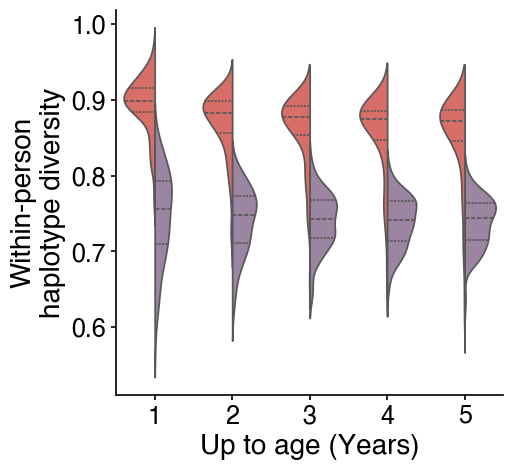

In [36]:
#hds.groupby(['lociType'])['Hd'].agg(['median','var'])
#stat, p = st.mannwhitneyu(hds[(hds.lociType=='ctrl') & (hds.permuted==0)]['Hd'],hds[(hds.lociType=='test')& (hds.permuted==0)]['Hd'],alternative='less')
fig,ax = plt.subplots(figsize=(5,5))
sns.violinplot(data=hds[hds.Age<=5],x='Age',y='Hd', hue='lociType',ax=ax,dodge=True,palette = ['#EB5E55','#9E81A5'],legend=False,split=True,inner='quart',hue_order = ['test','ctrl'])
ax.set_ylabel('Within-person\nhaplotype diversity')
ax.set_xlabel('Up to age (Years)')
#ax.text(0.5,0.2,f'Wilcoxon test p-value: {p:.2e}',transform=ax.transAxes,ha='center')
fig.savefig('figs/hd_year.pdf',bbox_inches='tight')

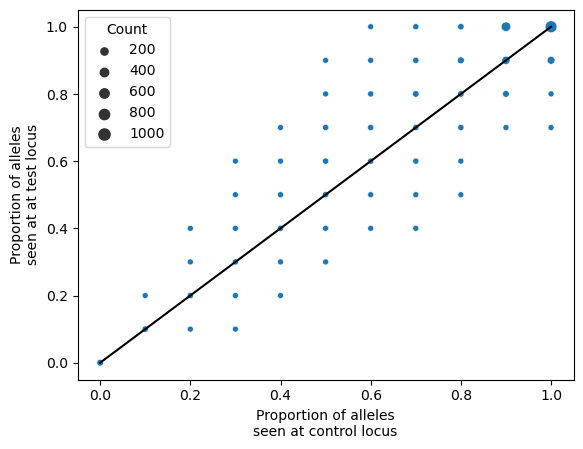

In [287]:
fig,ax = plt.subplots()
grouped = infections.groupby(['propTestPop','propCtrlPop']).agg('size').reset_index()
grouped['Count'] = grouped[0]
sns.scatterplot(data=grouped,y='propTestPop',x='propCtrlPop',ax=ax,size='Count')
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='k')
ax.set_xlabel('Proportion of alleles\nseen at control locus')
ax.set_ylabel('Proportion of alleles\nseen at at test locus')
plt.show()

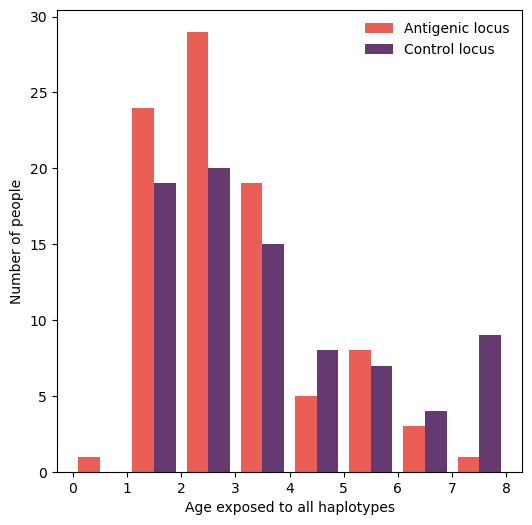

In [288]:
fig, ax = plt.subplots(figsize=(6,6))
test = []
ctrl = []
for person in infections.person.unique():
    if len(infections[(infections.person==person) & (infections.propTestPop==1)]['age']):
        DaysTest = min(infections[(infections.person==person) & (infections.propTestPop==1)]['age'])
        test.append(DaysTest/365)
    if len(infections[(infections.person==person) & (infections.propCtrlPop==1)]['age']):
        DaysCtrl = min(infections[(infections.person==person) & (infections.propCtrlPop==1)]['age'])
        ctrl.append(DaysCtrl/365)
ax.hist([test,ctrl],label=['Antigenic locus','Control locus'],color=['#EB5E55','#643A71'],bins=np.arange(0,9,1))
ax.set_xlabel('Age exposed to all haplotypes')
ax.set_ylabel('Number of people')
ax.legend(frameon=False)
fig.savefig('figs/timeSeen.pdf',dpi=300,bbox_inches='tight')

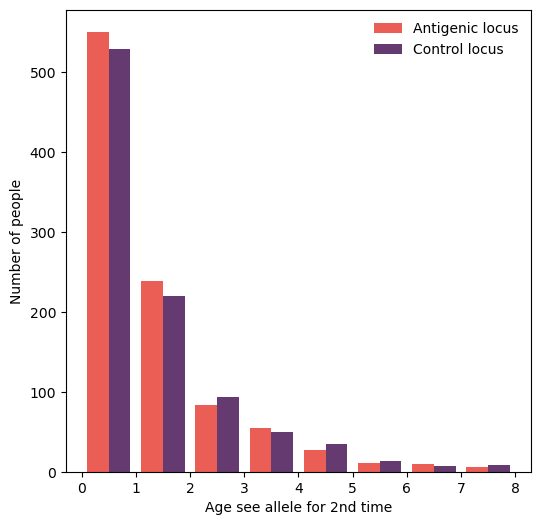

In [289]:
fig, ax = plt.subplots(figsize=(6,6))
test = []
ctrl = []
for person in clones.person.unique():
    for clone in range(10):
        if len(clones[(clones.person==person) & (clones.clone==clone) & (clones.nAllele==1) & (clones.lociType=='test')]['age']):
            Day2 = min(clones[(clones.person==person) & (clones.clone==clone) & (clones.nAllele==1) & (clones.lociType=='test')]['age'])
            test.append(Day2/365)
        if len(clones[(clones.person==person) & (clones.clone==clone) & (clones.nAllele==1) & (clones.lociType=='ctrl')]['age']):
            DaysCtrl = min(clones[(clones.person==person) & (clones.clone==clone) & (clones.nAllele==1) & (clones.lociType=='ctrl')]['age'])
            ctrl.append(DaysCtrl/365)
ax.hist([test,ctrl],label=['Antigenic locus','Control locus'],color=['#EB5E55','#643A71'],bins=np.arange(0,9,1))
ax.set_xlabel('Age see allele for 2nd time')
ax.set_ylabel('Number of people')
ax.legend(frameon=False)
#fig.savefig('figs/timeSeen.pdf',dpi=300,bbox_inches='tight')

In [290]:
fig, ax = plt.subplots()
ax.scatter[infections['propCtrlPop'],infections['propTestPop'])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (4064927294.py, line 2)

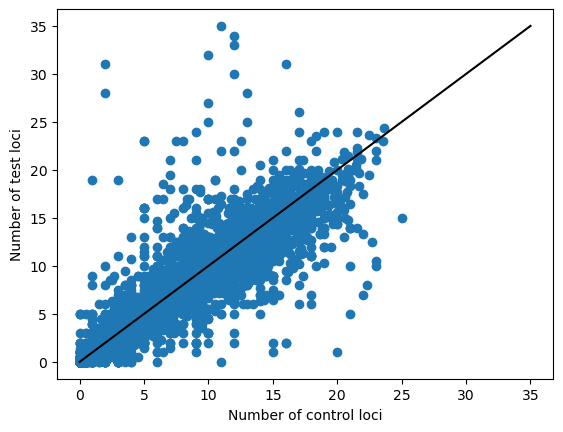

In [291]:
fig, ax = plt.subplots()
ax.scatter(infections['nCtrl'],infections['nTest'])
ax.set_xlabel('Number of control loci')
ax.set_ylabel('Number of test loci')
ax.plot(np.linspace(0,35,100),np.linspace(0,35,100),color='k')
plt.show()

In [318]:

new_df = merged.groupby(['lociType','clone','person','popFreq','simFreq','personFreq','popSimFreq'])['nAllele'].agg('max').reset_index()

In [319]:
new_df[(new_df.clone==1)&(new_df.person==0)]

,lociType,clone,person,popFreq,simFreq,personFreq,popSimFreq,nAllele
9,ctrl,1,0,0.042228,0.026915,0.049689,0.028489,7
109,test,1,0,0.051268,0.035197,0.057325,0.029927,8


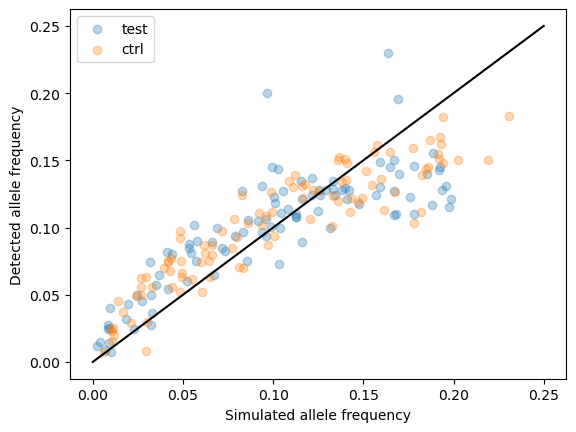

In [333]:
fig,ax = plt.subplots()
locs = ['test','ctrl']
for loci in locs:
    filt = new_df[new_df.lociType==loci]
    ax.scatter(filt['simFreq'],filt['personFreq'],label=loci,alpha=0.3)
#data = [new_df[new_df.lociType==loc]['nAllele'] for loc in locs]
#ax.hist(data,label=locs,bins=np.arange(0,35,1))
ax.legend()
ax.set_xlabel('Simulated allele frequency')
ax.set_ylabel('Detected allele frequency')
ax.plot(np.linspace(0,0.25,100),np.linspace(0,0.25,100),color='k')
plt.show()

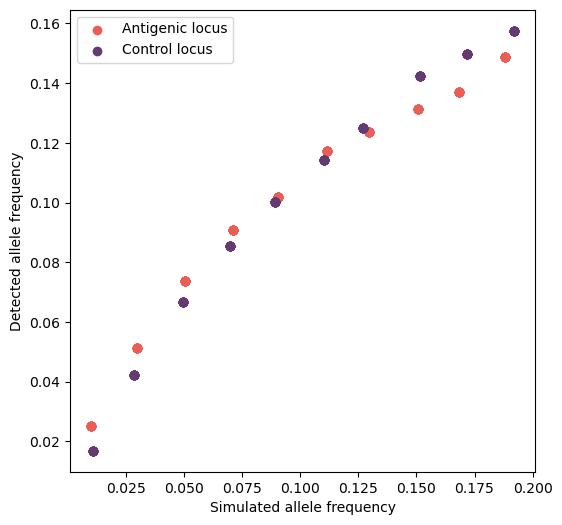

In [321]:
fig,ax = plt.subplots(figsize=(6,6))
locs = ['test','ctrl']
for color, loci,lab in zip(['#EB5E55','#643A71'],locs,['Antigenic locus','Control locus']):
    filt = new_df[new_df.lociType==loci]
    ax.scatter(filt['popSimFreq'],filt['popFreq'],label=lab,alpha=1,c=color)
    x = filt['popSimFreq']
    y = filt['popFreq']
    a, b = np.polyfit(x, y, 1)
    x_sim = np.linspace(0,0.2,100)
    y_sim = a * x_sim + b
    #ax.plot(x_sim,y_sim,c=color)
#data = [new_df[new_df.lociType==loc]['nAllele'] for loc in locs]
#ax.hist(data,label=locs,bins=np.arange(0,35,1))
ax.legend()
ax.set_xlabel('Simulated allele frequency')
ax.set_ylabel('Detected allele frequency')
#ax.plot(np.linspace(0,0.2,100),np.linspace(0,0.2,100),color='k')

plt.show()
fig.savefig('figs/balancing.pdf',dpi=300,bbox_inches='tight')

In [449]:
Average number of exposures at all loci is more correlated with number of exposues at individual alleles for control alleles.

SyntaxError: invalid syntax (3357947656.py, line 1)

In [25]:
clones.columns

Index(['person', 'clone', 'lociType', 'pdens', 'relativeFreq', 'age',
       'timeSinceAllele', 'nAllele', 'logPdens', 'SeenBefore', 'deltaPdens',
       'deltaFreq', 'nInfections', 'nClones', 'popFreq', 'rate'],
      dtype='object')

In [26]:
import scipy.interpolate
from matplotlib.cm import ScalarMappable
lowess = sm.nonparametric.lowess
def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), 50, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = lowess(y_s,x_s, frac=(2/3), it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

    
    
    
def get_lowess(ltype,df,var,outcome):
    filt = df[(df.lociType==ltype) & (df[var].notnull())]
    y = np.array(filt[outcome])
    x = np.array(filt[var])
    xgrid = np.linspace(x.min(),x.max())
    K = 100
    smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T
    return xgrid,smooths

def get_loess(lType,df):
    filt = df[df.lociType==ltype]
    x = filt['age']
    y = filt['nAllele']
    l = loess(x,y)
    l.fit()
    pred = l.predict(x, stderror=True)
    conf = pred.confidence()

    lowess = pred.values
    ll = conf.lower
    ul = conf.upper
    return x,y,lowess,ll,ul

In [21]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 20
mpl.rcParams['legend.fontsize']=18
mpl.rcParams['legend.title_fontsize']=20

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


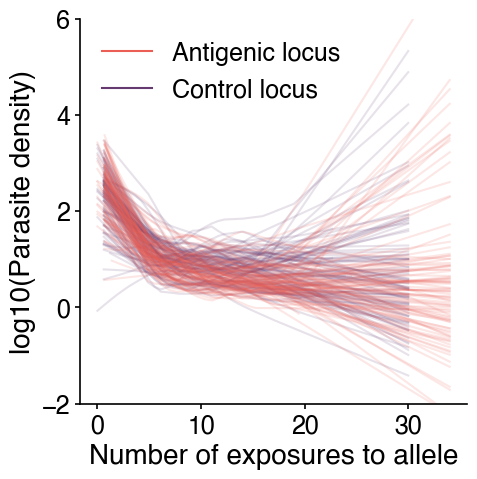

In [33]:

fig, ax = plt.subplots(ncols=1,figsize=(5,5))
#sns.histplot(data=clones[clones.lociType=='ctrl'], x="age", y="nAllele",ax=ax[0],color='#1f77b4')
#sns.histplot(data=clones[clones.lociType=='test'], x="age", y="nAllele",ax=ax[1],color='#2ca02c')

x_ctrl,y_ctrl = get_lowess('ctrl',clones,'nAllele','logPdens')
x_test,y_test = get_lowess('test',clones,'nAllele','logPdens')
ax.plot(x_ctrl,y_ctrl,label='Control locus',c='#643A71',alpha=0.15)
ax.plot(x_test,y_test,label='Antigenic locus',c='#EB5E55',alpha=0.15)
ax.set_xlabel('Number of exposures to allele')
ax.set_ylabel('log10(Parasite density)')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
leg = plt.legend(handles, labels, loc='best',frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_ylim(-2,6)
plt.show()
fig.savefig('figs/pdens_exposure_locus.pdf',bbox_inches='tight')

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


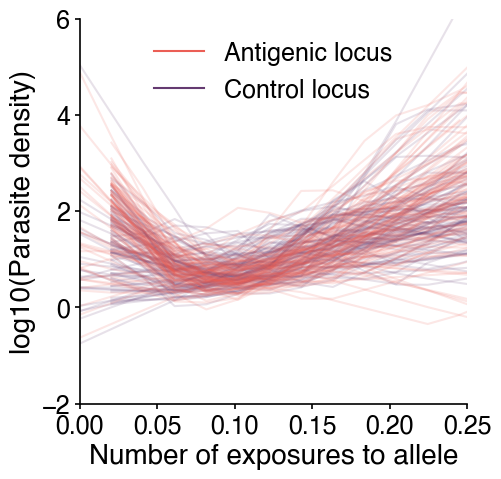

In [32]:

fig, ax = plt.subplots(ncols=1,figsize=(5,5))
#sns.histplot(data=clones[clones.lociType=='ctrl'], x="age", y="nAllele",ax=ax[0],color='#1f77b4')
#sns.histplot(data=clones[clones.lociType=='test'], x="age", y="nAllele",ax=ax[1],color='#2ca02c')

x_ctrl,y_ctrl = get_lowess('ctrl',merged,'nNumber','logPdensClone')
x_test,y_test = get_lowess('test',merged,'nNumber','logPdensClone')
ax.plot(x_ctrl,y_ctrl,label='Control locus',c='#643A71',alpha=0.15)
ax.plot(x_test,y_test,label='Antigenic locus',c='#EB5E55',alpha=0.15)
ax.set_xlabel('Number of exposures to allele')
ax.set_ylabel('log10(Parasite density)')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
leg = plt.legend(handles, labels, loc='best',frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_ylim(-2,6)
ax.set_xlim(0,0.25)
plt.show()

In [154]:
clones

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele
0,0,8,test,15821.163089,0.995731,11,11,0
1,0,2,ctrl,15821.163089,0.995731,11,11,0
2,0,2,test,244.862777,0.015186,62,62,0
3,0,9,test,15875.975761,0.984616,62,62,0
4,0,5,ctrl,248.059124,0.015384,62,62,0
...,...,...,...,...,...,...,...,...
29672,99,4,ctrl,1.090521,0.030852,2857,84,15
29673,99,6,ctrl,9.194381,0.260115,2857,84,12
29674,99,7,ctrl,9.559062,0.270432,2857,84,23
29675,99,8,ctrl,1.909937,0.054033,2857,84,17


/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


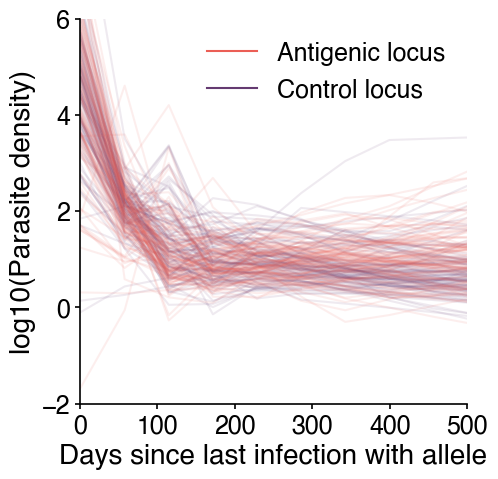

In [35]:
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
#

x_ctrl,y_ctrl = get_lowess('ctrl',clones,'timeSinceAllele','logPdens')
x_test,y_test = get_lowess('test',clones,'timeSinceAllele','logPdens')
ax.plot(x_ctrl,y_ctrl,label='Control locus',c='#643A71',alpha=0.1)
ax.plot(x_test,y_test,label='Antigenic locus',c='#EB5E55',alpha=0.1)
ax.set_xlabel('Days since last infection with allele')
ax.set_ylabel('log10(Parasite density)')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
leg = plt.legend(handles, labels, loc='best',frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.set_ylim(-2,6)
ax.set_xlim(0,500)
plt.show()
fig.savefig('figs/pdens_daySince_locus.pdf',bbox_inches='tight')

In [37]:
merged.columns

Index(['person', 'clone', 'lociType', 'pdens_x', 'relativeFreq', 'age',
       'timeSinceAllele', 'nAllele', 'logPdens_x', 'SeenBefore',
       'deltaPdens_x', 'deltaFreq', 'pdens_y', 'symptomatic', 'infectNumber',
       'COIinfection', 'clonesBefore', 'malariaNumber', 'timeSince',
       'timeSinceSymp', 'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl',
       'propTestSeen', 'propCtrlSeen', 'propTestPop', 'propCtrlPop',
       'logPdens_y', 'TestBefore', 'CtrlBefore', 'deltaPdens_y',
       'logPdensClone', 'logPdensInfection', 'nNumber', 'time'],
      dtype='object')

In [39]:
merged.time

0              inf
1              inf
2              inf
3              inf
4        37.000000
           ...    
29574     0.656250
29575     0.646154
29576     0.646154
29577    13.363636
29578     1.909091
Name: time, Length: 29579, dtype: float64

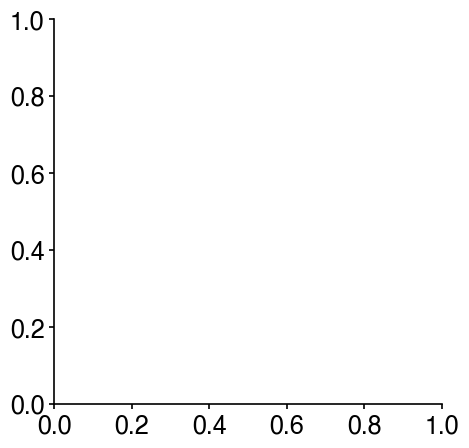

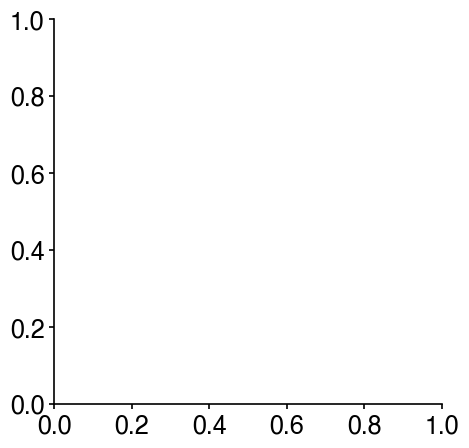

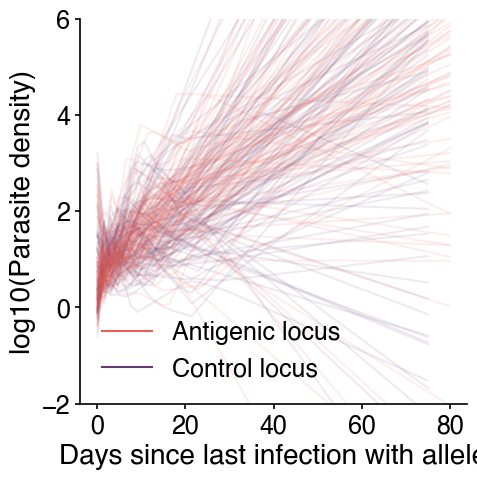

In [43]:
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
#

x_ctrl,y_ctrl = get_lowess('ctrl',merged[np.isfinite(merged.time)],'time','logPdensClone')
x_test,y_test = get_lowess('test',merged[np.isfinite(merged.time)],'time','logPdensClone')
ax.plot(x_ctrl,y_ctrl,label='Control locus',c='#643A71',alpha=0.1)
ax.plot(x_test,y_test,label='Antigenic locus',c='#EB5E55',alpha=0.1)
ax.set_xlabel('Days since last infection with allele')
ax.set_ylabel('log10(Parasite density)')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
leg = plt.legend(handles, labels, loc='best',frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.set_ylim(-2,6)
#ax.set_xlim(0,500)
plt.show()
#fig.savefig('figs/pdens_daySince_locus.pdf',bbox_inches='tight')

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


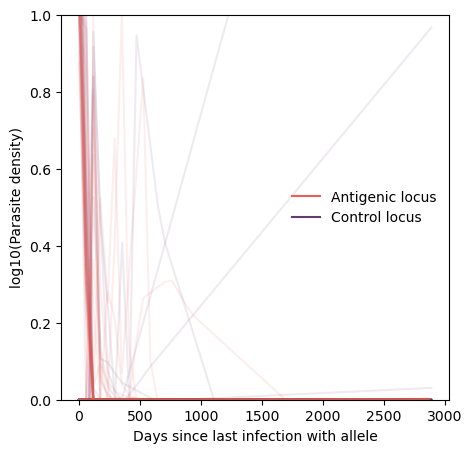

In [196]:
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
#

x_ctrl,y_ctrl = get_lowess('ctrl',merged,'timeSinceAllele','symptomatic')
x_test,y_test = get_lowess('test',merged,'timeSinceAllele','symptomatic')
ax.plot(x_ctrl,y_ctrl,label='Control locus',c='#643A71',alpha=0.1)
ax.plot(x_test,y_test,label='Antigenic locus',c='#EB5E55',alpha=0.1)
ax.set_xlabel('Days since last infection with allele')
ax.set_ylabel('log10(Parasite density)')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
leg = plt.legend(handles, labels, loc='best',frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
#ax.set_xlim(0,500)
ax.set_ylim(0,1)
plt.show()

In [195]:
merged.symptomatic

0        1
1        1
2        1
3        1
4        1
        ..
29672    0
29673    0
29674    0
29675    0
29676    0
Name: symptomatic, Length: 29677, dtype: int64

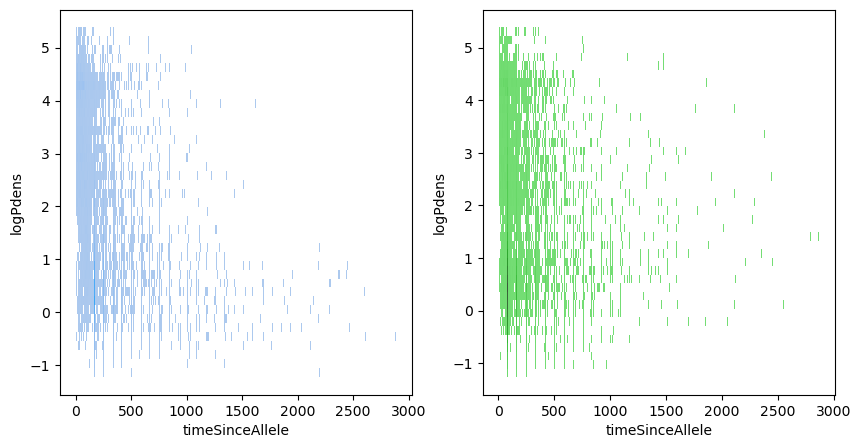

In [182]:
fig, ax = plt.subplots(ncols=2,figsize=(10,5))

sns.histplot(data=clones[clones.lociType=='ctrl'], y="logPdens", x="timeSinceAllele",ax=ax[0],color='#1f77b4')
sns.histplot(data=clones[clones.lociType=='test'], y="logPdens", x="timeSinceAllele",ax=ax[1],color='#2ca02c')
plt.show()

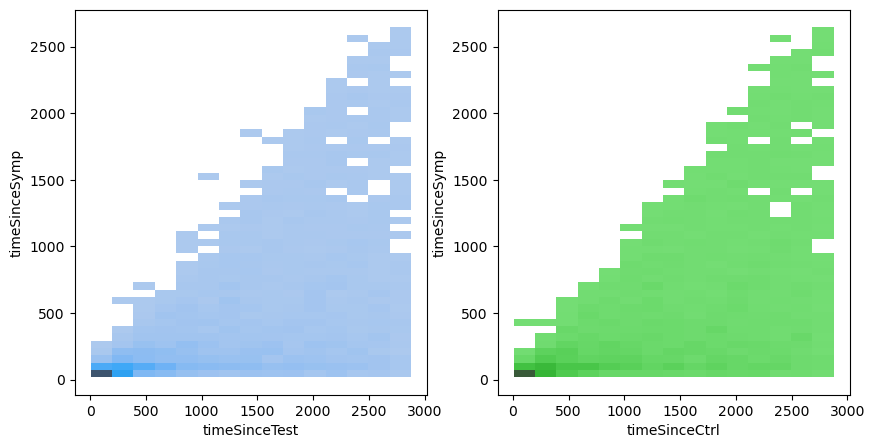

In [322]:
fig, ax = plt.subplots(ncols=2,figsize=(10,5))

sns.histplot(data=infections, y="timeSinceSymp", x="timeSinceTest",ax=ax[0],color='#1f77b4')
sns.histplot(data=infections, y="timeSinceSymp", x="timeSinceCtrl",ax=ax[1],color='#2ca02c')
plt.show()

_______________________________________
## Side bar: Do my estimated infections actually match up with true infections?

In [220]:
infectNumber = pd.DataFrame({'estimated':infections.groupby('person')['infectNumber'].max()}).reset_index()
infectNumber['actual'] = [len(all_strains[person]) for person in all_strains.keys()]
infectNumber['malaria'] = [len(all_malaria[person]) for person in all_malaria.keys()]

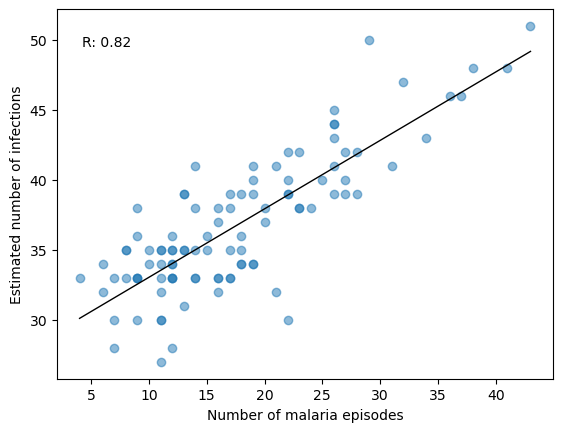

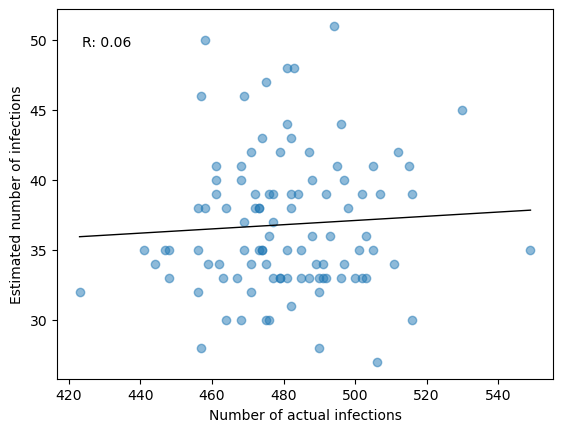

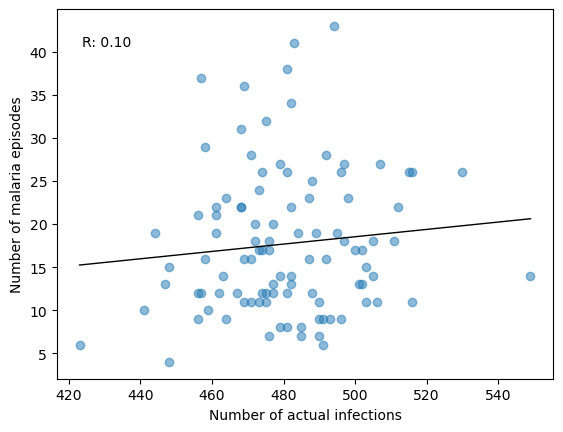

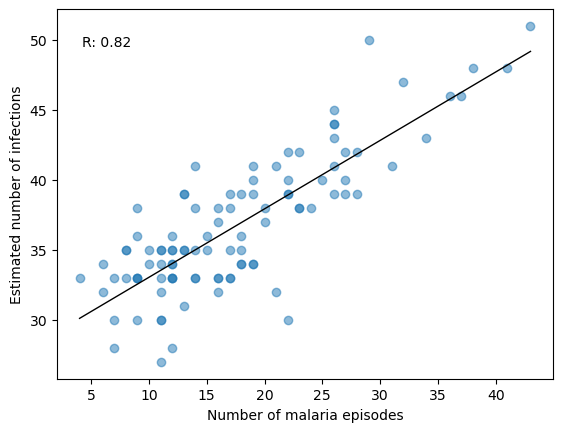

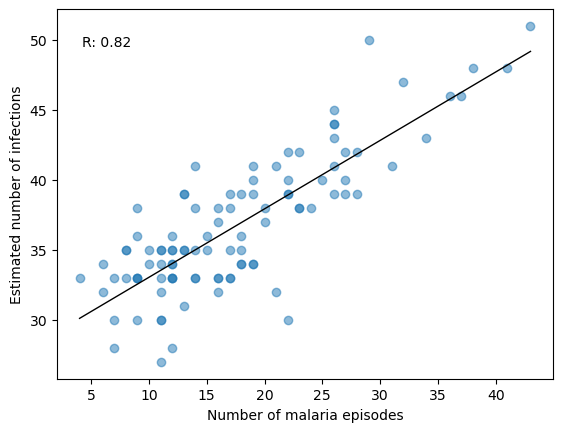

In [225]:
plot_scatter(infectNumber.malaria,infectNumber.estimated,'Number of malaria episodes','Estimated number of infections')
plt.show()

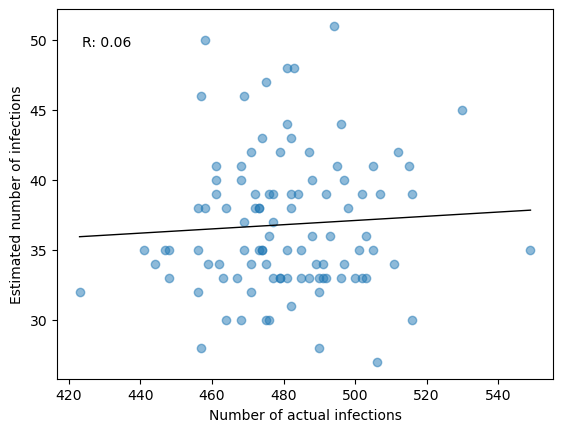

In [226]:
plot_scatter(infectNumber.actual,infectNumber.estimated,'Number of actual infections','Estimated number of infections')
plt.show()

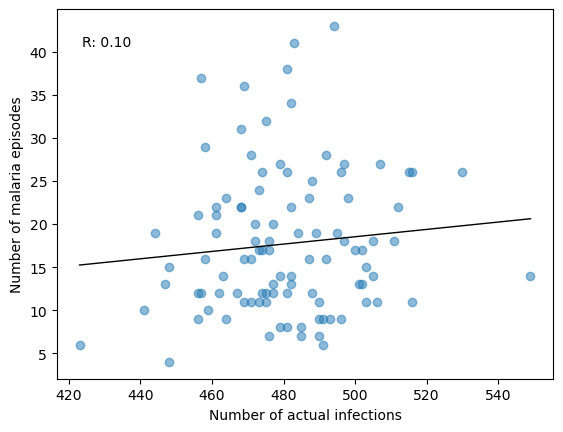

In [227]:
plot_scatter(infectNumber.actual,infectNumber.malaria,'Number of actual infections','Number of malaria episodes')
plt.show()

In [317]:
def get_stats(infections):
    infectNumber = pd.DataFrame({'estimated':infections.groupby('person')['infectNumber'].max()}).reset_index()
    infectNumber['actual'] = [len(all_strains[person]) for person in all_strains.keys()]
    m = np.corrcoef(infectNumber['actual'], infectNumber['estimated'])
    r = m[0,1]
    avg = np.mean(infectNumber.estimated)
    return r, avg

def find_correlation():
    results = {
        'sim':[],
        'skew':[],
        'clones':[],
        'period':[],
        'lod':[],
        'r':[],
        'avgInfections':[]
    }
    for i in range(10):
        for power in [1,2,3]:
            for ama1 in [10,50,100]:
                a[8] = ama1
                all_parasites,all_immunity,all_strains,all_malaria,all_bites = sim.simulate_cohort(n_people,y,eir,a,w,power=power)
                for v in [7,14,56,84]:
                    all_visits = grab_visits(all_malaria,v,y)
                    for thresh in [100,10,1,0.1,0.01]:
                        infections,clones = infer_infect_AMA1(all_parasites,all_malaria,all_visits,8,9,0,thresh=thresh)
                        r,avg = get_stats(infections)
                        results['sim'].append(i)
                        results['skew'].append(power)
                        results['clones'].append(ama1)
                        results['period'].append(v)
                        results['lod'].append(thresh)
                        results['r'].append(r)
                        results['avgInfections'].append(avg)
        df = pd.DataFrame(results)
    return df

In [318]:
corrDF = find_correlation()

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/code/pfMech.py:169: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/cwagner

In [341]:
corrDF

,sim,skew,clones,period,lod,r,avgInfections
0,0,1,10,7,100.00,-0.098331,70.99
1,0,1,10,7,10.00,-0.007022,140.80
2,0,1,10,7,1.00,0.020432,187.11
3,0,1,10,7,0.10,-0.003697,191.96
4,0,1,10,7,0.01,-0.000746,191.95
...,...,...,...,...,...,...,...
1795,9,3,100,84,100.00,-0.047289,19.16
1796,9,3,100,84,10.00,-0.090859,24.79
1797,9,3,100,84,1.00,-0.008789,26.33
1798,9,3,100,84,0.10,-0.010722,26.71


Text(0.5, 0, 'Limit of detection')

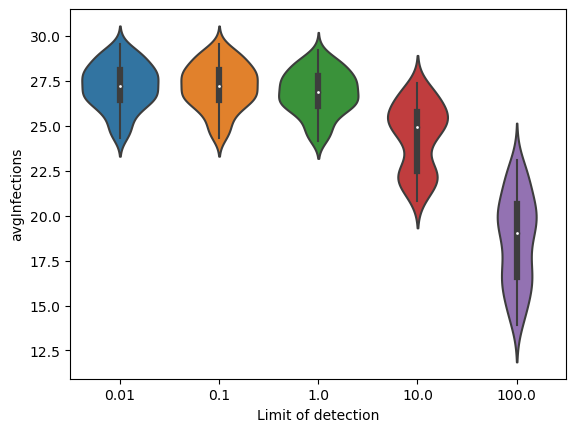

In [381]:
ax = sns.violinplot(data=corrDF[corrDF.period==84], x="lod", y="avgInfections")
ax.set_xlabel('Limit of detection')
#[(corrDF.period==84) & (corrDF.clones==50) & (corrDF['skew']==2)]

Text(0.5, 0, 'Limit of detection')

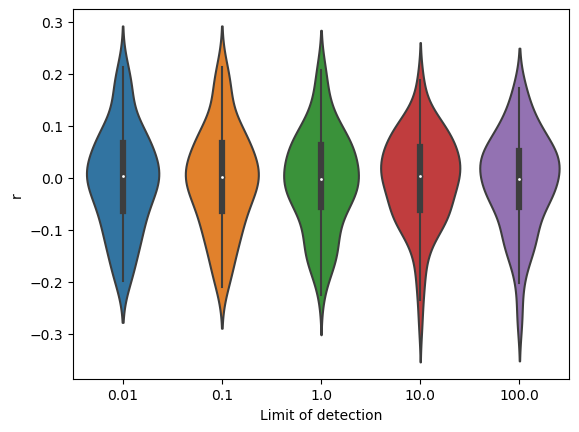

In [384]:
ax = sns.violinplot(data=corrDF[corrDF.period==84], x="lod", y="r")
ax.set_xlabel('Limit of detection')
#[(corrDF.period==84) & (corrDF.clones==50) & (corrDF['skew']==2)]

Text(0.5, 0, 'Days between scheduled visits')

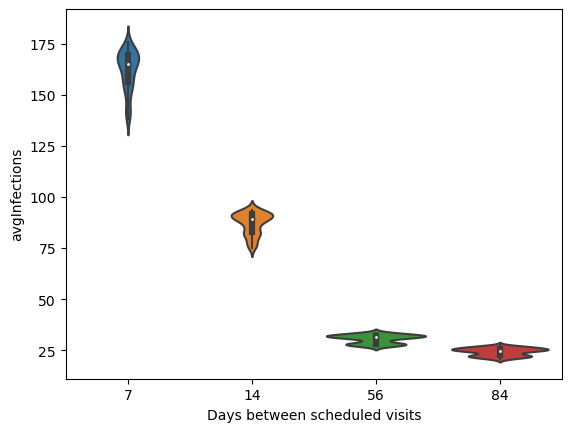

In [382]:
ax = sns.violinplot(data=corrDF[corrDF.lod==10], x="period", y="avgInfections")
ax.set_xlabel('Days between scheduled visits')
#[(corrDF.lod==10) & (corrDF.clones==50) & (corrDF['skew']==2)]

Text(0.5, 0, 'Days between scheduled visits')

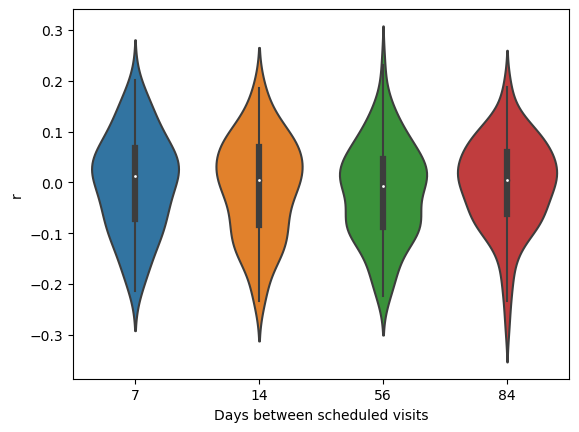

In [385]:
ax = sns.violinplot(data=corrDF[corrDF.lod==10], x="period", y="r")
ax.set_xlabel('Days between scheduled visits')
#[(corrDF.lod==10) & (corrDF.clones==50) & (corrDF['skew']==2)]

Text(0.5, 0, 'Skew of allele frequency')

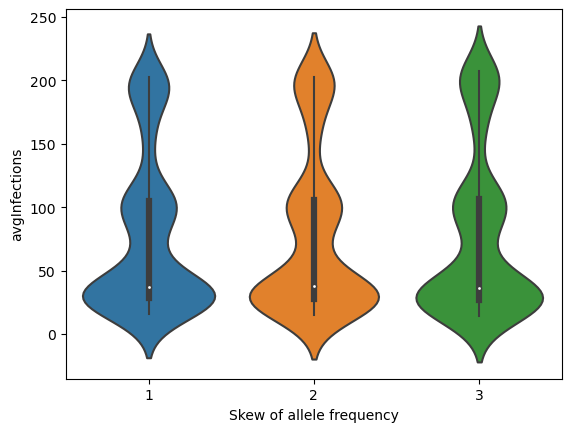

In [387]:
ax = sns.violinplot(data=corrDF, x="skew", y="avgInfections")
ax.set_xlabel('Skew of allele frequency')
#[(corrDF.period==84) & (corrDF.clones==100) & (corrDF.lod==10)]

Text(0.5, 0, 'Skew of allele frequency')

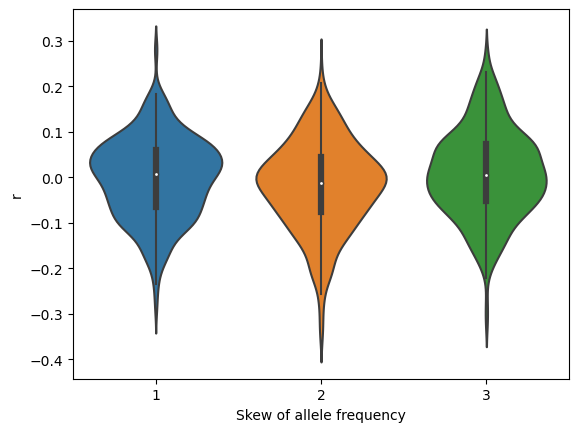

In [386]:
ax = sns.violinplot(data=corrDF, x="skew", y="r")
ax.set_xlabel('Skew of allele frequency')
#[(corrDF.period==84) & (corrDF.clones==100) & (corrDF.lod==10)]

Text(0.5, 0, 'Number of clones in population')

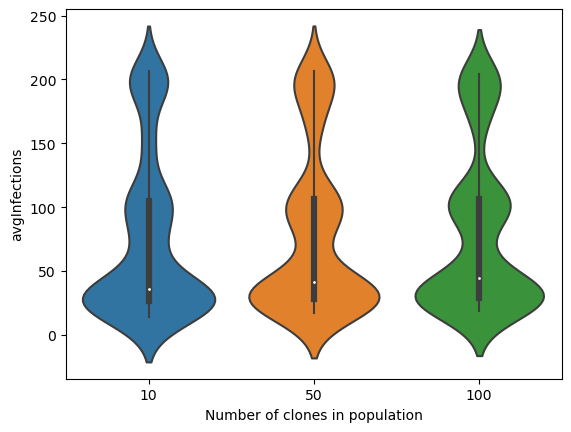

In [388]:
ax = sns.violinplot(data=corrDF, x="clones", y="avgInfections")
ax.set_xlabel('Number of clones in population')
#[(corrDF.period==84) & (corrDF['skew']==1)  & (corrDF.lod==10) ]

Text(0.5, 0, 'Number of clones in population')

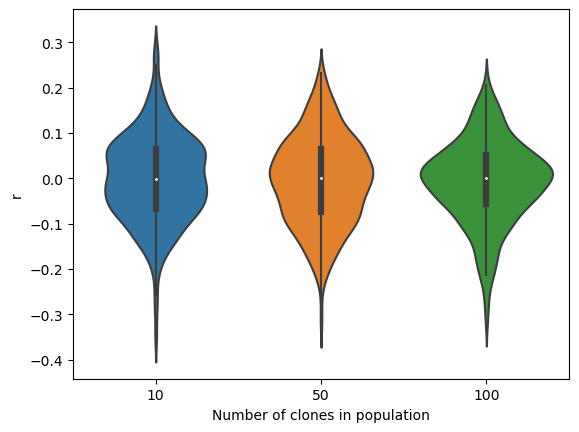

In [383]:
ax = sns.violinplot(data=corrDF, x="clones", y="r")
ax.set_xlabel('Number of clones in population')
#[(corrDF.period==84) & (corrDF['skew']==1)  & (corrDF.lod==10) ]

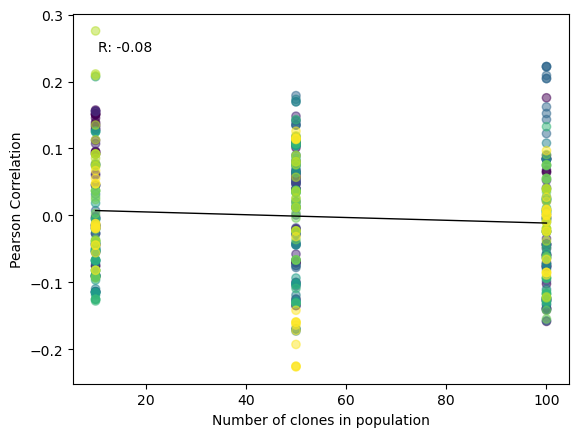

In [269]:
fig, ax = plt.subplots()
x = corrDF['clones'],
y = corrDF['r'],'Number of clones in population', 'Pearson Correlation',color=corrDF['sim'])

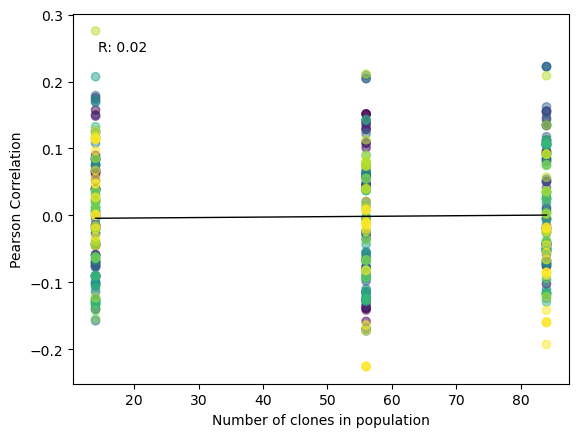

In [270]:
plot_scatter(corrDF['period'],corrDF['r'],'Number of clones in population', 'Pearson Correlation',color=corrDF['sim'])

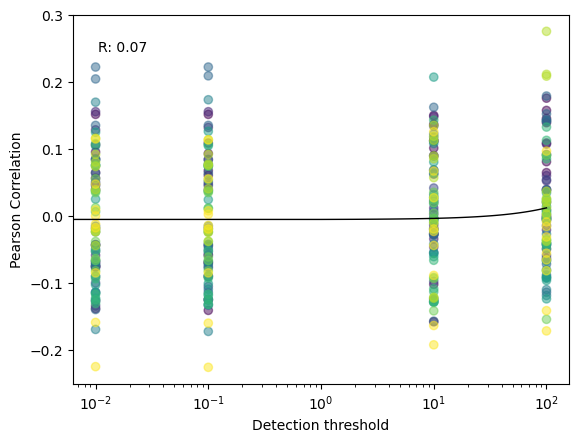

In [275]:
plot_scatter(corrDF['lod'],corrDF['r'],'Detection threshold', 'Pearson Correlation',color=corrDF['sim'],logx=True)

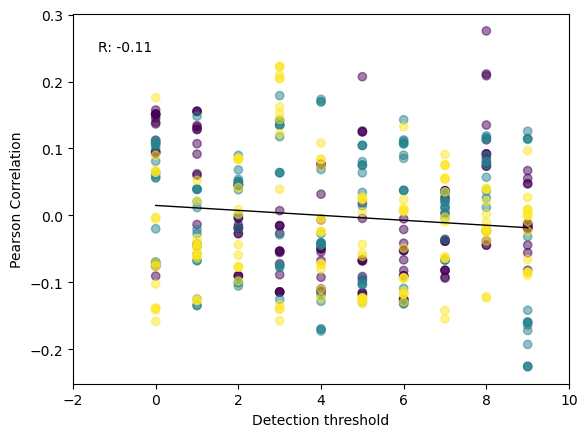

In [285]:
plot_scatter(corrDF['sim'],corrDF['r'],'Detection threshold', 'Pearson Correlation',color=corrDF['clones'])

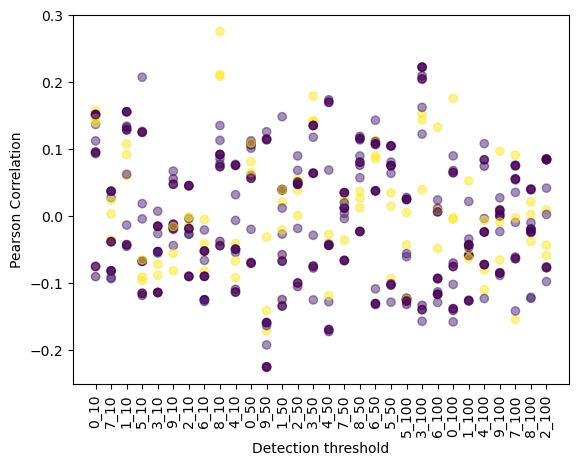

In [292]:
corrDF['unique'] = corrDF['sim'].astype(str) + '_' + corrDF['clones'].astype(str)
corrDF = corrDF.sort_values(by=['clones'])
plot_scatter(corrDF['unique'],corrDF['r'],'Detection threshold', 'Pearson Correlation',color=corrDF['lod'],xticksrot=90,corr=False)

The answer is not really. There is poor correlation, and it seems to be pretty stochastic, i.e. I can't find a pattern to explain this poor correlation. Let's move on to finding ways to identify antigenic loci.
______________________
## Testing ways to identify antigenic loci

In [228]:
infections.columns

Index(['person', 'pdens', 'symptomatic', 'infectNumber', 'COIinfection',
       'clonesBefore', 'malariaNumber', 'age', 'timeSince', 'timeSinceSymp',
       'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen',
       'propCtrlSeen', 'propTestPop', 'propCtrlPop', 'logPdens', 'TestBefore',
       'CtrlBefore', 'deltaPdens'],
      dtype='object')

In [229]:
infections.head()

,person,pdens,symptomatic,infectNumber,COIinfection,clonesBefore,malariaNumber,age,timeSince,timeSinceSymp,...,nTest,nCtrl,propTestSeen,propCtrlSeen,propTestPop,propCtrlPop,logPdens,TestBefore,CtrlBefore,deltaPdens
0,0,16171.380667,1,1,4,0,0,21,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.208747,0,0,NaN
1,0,20671.424704,1,2,3,4,1,56,35.0,35.0,...,0.000000,0.666667,0.000000,0.666667,0.2,0.4,4.315370,0,0,0.106623
2,0,37.577223,0,3,5,7,2,93,37.0,37.0,...,0.400000,0.750000,0.400000,0.750000,0.5,0.5,1.574925,0,0,-2.740446
3,0,19057.678952,1,4,3,12,2,175,82.0,119.0,...,1.333333,1.000000,1.000000,0.666667,0.8,0.6,4.280070,1,1,2.705145
4,0,16017.733171,1,5,3,15,3,237,62.0,62.0,...,1.000000,2.333333,0.666667,1.000000,0.8,0.7,4.204601,1,1,-0.075469


In [230]:
clones.columns

Index(['person', 'clone', 'lociType', 'pdens', 'relativeFreq', 'age',
       'timeSinceAllele', 'nAllele', 'logPdens', 'SeenBefore', 'deltaPdens',
       'deltaFreq', 'nInfections', 'nClones', 'popFreq', 'rate'],
      dtype='object')

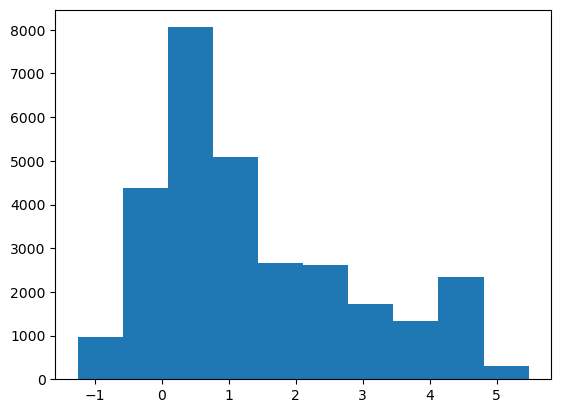

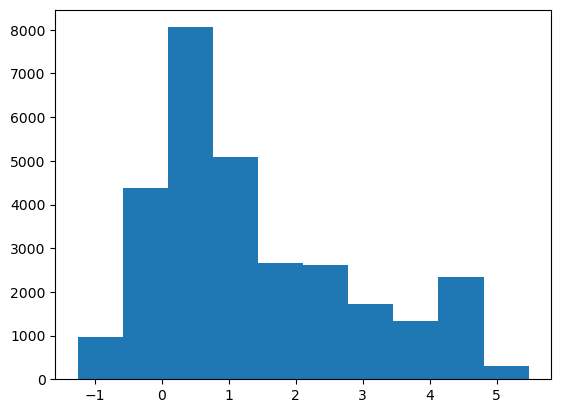

In [232]:
fig,ax = plt.subplots()
ax.hist(clones['logPdens'])
plt.show()

In [44]:
infections['logPdens'] = np.log10(infections.pdens)
clones['logPdens'] = np.log10(clones.pdens)
infections['TestBefore'] = np.where(infections['nTest']<1,0,1)
infections['CtrlBefore'] = np.where(infections['nCtrl']<1,0,1)
clones['SeenBefore'] = np.where(clones['nAllele']>0,1,0)
infections['deltaPdens'] = infections['logPdens'] - np.roll(infections['logPdens'],1)
infections['deltaPdens'] = np.where(infections.infectNumber==1, np.nan,infections['deltaPdens'])
clones['deltaPdens'] = clones.groupby(['person','clone','lociType'],group_keys=False)['logPdens'].apply(lambda x: x - np.roll(x,1))
clones['deltaPdens'] = np.where(clones.nAllele==0,np.nan,clones['deltaPdens'])
clones['deltaFreq'] = clones.groupby(['person','clone','lociType'],group_keys=False)['relativeFreq'].apply(lambda x: x - np.roll(x,1))
clones['deltaFreq'] = np.where(clones.nAllele==0,np.nan,clones['deltaFreq'])

In [45]:
clones.head()

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele,logPdens,SeenBefore,deltaPdens,deltaFreq,nInfections,nClones,popFreq,rate
0,0,5,test,45403.397121,0.987479,22,22,0,4.657088,0,NaN,NaN,14996,1680,0.112030,0.045455
1,0,7,test,548.105875,0.011921,22,22,0,2.738864,0,NaN,NaN,14996,1947,0.129835,0.045455
2,0,5,ctrl,45404.182472,0.987496,22,22,0,4.657096,0,NaN,NaN,14583,1660,0.113831,0.045455
3,0,6,ctrl,546.294996,0.011881,22,22,0,2.737427,0,NaN,NaN,14583,1834,0.125763,0.045455
4,0,9,test,42811.850976,0.998583,74,74,0,4.631564,0,NaN,NaN,14996,2190,0.146039,0.013514


In [46]:
clones[(clones.person==0) & (clones.clone==1) & (clones.lociType=='test')].head()

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele,logPdens,SeenBefore,deltaPdens,deltaFreq,nInfections,nClones,popFreq,rate
27,0,1,test,21063.393151,0.999093,251,251,0,4.323528,0,NaN,NaN,14996,855,0.057015,0.003984
73,0,1,test,3.613473,0.026082,862,611,1,0.557925,1,-3.765604,-0.973011,14996,855,0.057015,0.001637
87,0,1,test,4.056649,0.052796,946,84,2,0.608167,1,0.050243,0.026714,14996,855,0.057015,0.011905
103,0,1,test,0.649235,0.033878,1030,84,3,-0.187598,1,-0.795766,-0.018918,14996,855,0.057015,0.011905
151,0,1,test,176.358284,0.030350,1870,840,4,2.246396,1,2.433994,-0.003528,14996,855,0.057015,0.001190


In [47]:
infections.head()

,person,pdens,symptomatic,infectNumber,COIinfection,clonesBefore,malariaNumber,age,timeSince,timeSinceSymp,...,nTest,nCtrl,propTestSeen,propCtrlSeen,propTestPop,propCtrlPop,logPdens,TestBefore,CtrlBefore,deltaPdens
0,0,45979.082966,1,1,2,0,0,22,NaN,NaN,...,0.000000,0.00,0.000000,0.00,0.0,0.0,4.662560,0,0,NaN
1,0,42872.606913,1,2,1,2,1,74,52.0,52.0,...,0.000000,0.00,0.000000,0.00,0.2,0.2,4.632180,0,0,-0.030380
2,0,66.877190,0,3,3,3,2,106,32.0,32.0,...,0.666667,0.00,0.666667,0.00,0.3,0.3,1.825278,0,0,-2.806902
3,0,8765.997632,0,4,2,6,2,190,84.0,116.0,...,1.250000,0.25,0.750000,0.25,0.4,0.5,3.942801,1,0,2.117523
4,0,15916.916252,1,5,2,8,2,205,15.0,131.0,...,2.250000,1.25,1.000000,1.00,0.5,0.8,4.201859,1,1,0.259058


In [48]:
np.roll(infections['logPdens'],1)

array([4.18800852, 4.66256031, 4.63217989, ..., 1.36421301, 3.28064697,
       5.22153616])

In [543]:
formula = 'logPdens ~ nTest + age + nCtrl'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 3691
Model:                            GLM   Df Residuals:                     3687
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.5130
Method:                          IRLS   Log-Likelihood:                -5999.5
Date:                Sun, 19 Nov 2023   Deviance:                       5578.4
Time:                        22:23:31   Pearson chi2:                 5.58e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1598
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7345      0.036    103.530      0.0

In [49]:
formula = 'logPdens ~ COIinfection + infectNumber + timeSinceCtrl + timeSinceTest'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 3262
Model:                            GLM   Df Residuals:                     3257
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                         0.72816
Method:                          IRLS   Log-Likelihood:                -4108.7
Date:                Sun, 19 Nov 2023   Deviance:                       2371.6
Time:                        15:39:29   Pearson chi2:                 2.37e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7360
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.1313      0.041    101.362

In [50]:
formula = 'logPdens ~ COIinfection + timeSince + malariaNumber + timeSinceTest + timeSinceCtrl'
model = smf.mixedlm(formula, infections[(infections.timeSince.notnull())&(infections.timeSinceTest.notnull()) &(infections.timeSinceCtrl.notnull())], groups=infections[(infections.timeSince.notnull())&(infections.timeSinceTest.notnull()) &(infections.timeSinceCtrl.notnull())]['person'])
result = model.fit()
print(result.summary())


          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: logPdens  
No. Observations:  3262    Method:             REML      
No. Groups:        100     Scale:              0.7159    
Min. group size:   21      Log-Likelihood:     -4123.1817
Max. group size:   51      Converged:          Yes       
Mean group size:   32.6                                  
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      4.248    0.045  95.133 0.000  4.161  4.336
COIinfection  -0.258    0.005 -55.418 0.000 -0.267 -0.249
timeSince     -0.002    0.000  -5.839 0.000 -0.003 -0.001
malariaNumber  0.016    0.004   4.252 0.000  0.009  0.024
timeSinceTest -0.000    0.000  -1.468 0.142 -0.000  0.000
timeSinceCtrl  0.000    0.000   0.342 0.732 -0.000  0.000
Group Var      0.002    0.004                            



/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [549]:
formula = 'logPdens ~ nTest + nCtrl + COIinfection + clonesBefore'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 3691
Model:                            GLM   Df Residuals:                     3686
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                         0.69281
Method:                          IRLS   Log-Likelihood:                -4557.5
Date:                Sun, 19 Nov 2023   Deviance:                       2553.7
Time:                        22:27:57   Pearson chi2:                 2.55e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7905
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3677      0.026    166.808   

In [548]:
formula = 'logPdens ~ nTest + nCtrl + COIinfection'
model = smf.mixedlm(formula, infections, groups=infections['person'])
result = model.fit()
print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logPdens  
No. Observations: 3691    Method:             REML      
No. Groups:       100     Scale:              0.7043    
Min. group size:  28      Log-Likelihood:     -4625.3678
Max. group size:  52      Converged:          Yes       
Mean group size:  36.9                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     4.392    0.029 154.088 0.000  4.336  4.448
nTest         0.025    0.004   5.670 0.000  0.017  0.034
nCtrl        -0.051    0.005 -10.790 0.000 -0.060 -0.042
COIinfection -0.271    0.004 -61.999 0.000 -0.279 -0.262
Group Var     0.009    0.005                            



/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [252]:
formula = 'logPdens ~ propTestSeen + propCtrlSeen + COIinfection + clonesBefore'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 3681
Model:                            GLM   Df Residuals:                     3676
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                         0.68444
Method:                          IRLS   Log-Likelihood:                -4522.8
Date:                Sun, 19 Nov 2023   Deviance:                       2516.0
Time:                        14:52:06   Pearson chi2:                 2.52e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7893
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.7666      0.049     97.173   

In [553]:
formula = 'logPdens ~ propTestSeen + propCtrlSeen + COIinfection + clonesBefore'
model = smf.mixedlm(formula, infections, groups=infections['person'])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logPdens  
No. Observations: 3691    Method:             REML      
No. Groups:       100     Scale:              0.6777    
Min. group size:  28      Log-Likelihood:     -4567.7607
Max. group size:  52      Converged:          Yes       
Mean group size:  36.9                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     4.813    0.050  96.322 0.000  4.715  4.911
propTestSeen -0.423    0.064  -6.565 0.000 -0.549 -0.297
propCtrlSeen -0.208    0.069  -3.013 0.003 -0.343 -0.073
COIinfection -0.254    0.004 -56.600 0.000 -0.263 -0.246
clonesBefore -0.002    0.000  -6.420 0.000 -0.003 -0.002
Group Var     0.017    0.006                            



In [304]:
formula = 'logPdens ~ propCtrlPop + propTestPop + infectNumber + COIinfection'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 3691
Model:                            GLM   Df Residuals:                     3686
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                         0.66363
Method:                          IRLS   Log-Likelihood:                -4478.1
Date:                Sun, 19 Nov 2023   Deviance:                       2446.1
Time:                        20:22:11   Pearson chi2:                 2.45e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7981
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.9495      0.050     99.204   

In [300]:
formula = 'logPdens ~ propTestPop + propCtrlPop + COIinfection'
model = smf.mixedlm(formula, infections, groups=infections['person'])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logPdens  
No. Observations: 3691    Method:             REML      
No. Groups:       100     Scale:              0.6452    
Min. group size:  28      Log-Likelihood:     -4476.7377
Max. group size:  54      Converged:          Yes       
Mean group size:  36.9                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     4.895    0.050  98.858 0.000  4.798  4.992
propTestPop  -0.702    0.159  -4.402 0.000 -1.014 -0.389
propCtrlPop  -0.142    0.159  -0.893 0.372 -0.454  0.170
COIinfection -0.267    0.004 -61.192 0.000 -0.276 -0.258
Group Var     0.021    0.007                            



In [634]:
formula = 'logPdens ~ TestBefore + CtrlBefore '
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                 2531
Model:                            GLM   Df Residuals:                     2528
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.3390
Method:                          IRLS   Log-Likelihood:                -3959.3
Date:                Tue, 14 Nov 2023   Deviance:                       3385.1
Time:                        21:55:35   Pearson chi2:                 3.39e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1296
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2963      0.071     60.516      0.0

I wonder if this dynamic would be different if more waning........
Proportion in population seen is significant, but that's the only thing that's robust to excluding or including covariates.
Now, let's look at symptomatic

In [514]:
infections.columns

Index(['person', 'pdens', 'symptomatic', 'infectNumber', 'COIinfection',
       'clonesBefore', 'malariaNumber', 'age', 'timeSince', 'timeSinceSymp',
       'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen',
       'propCtrlSeen', 'propTestPop', 'propCtrlPop', 'logPdens', 'TestBefore',
       'CtrlBefore', 'deltaPdens'],
      dtype='object')

In [636]:
formula = 'deltaPdens ~ COIinfection + clonesBefore + malariaNumber + timeSince + timeSinceTest + timeSinceCtrl'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                 2224
Model:                            GLM   Df Residuals:                     2220
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.9943
Method:                          IRLS   Log-Likelihood:                -3921.3
Date:                Tue, 14 Nov 2023   Deviance:                       4427.5
Time:                        21:57:40   Pearson chi2:                 4.43e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2125
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4487      0.063      7.117

In [639]:
formula = 'deltaPdens ~ COIinfection + timeSince +nTest + nCtrl'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2426
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          1.8711
Method:                          IRLS   Log-Likelihood:                -4208.5
Date:                Tue, 14 Nov 2023   Deviance:                       4539.2
Time:                        21:58:19   Pearson chi2:                 4.54e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2073
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1807      0.069      2.634   

In [533]:
formula = 'deltaPdens ~ COIinfection + timeSince +propTestSeen + propCtrlSeen'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2426
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          1.9126
Method:                          IRLS   Log-Likelihood:                -4235.2
Date:                Tue, 14 Nov 2023   Deviance:                       4640.0
Time:                        20:36:07   Pearson chi2:                 4.64e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1858
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0039      0.128     -0.030   

In [538]:
formula = 'deltaPdens ~ COIinfection + timeSince +propTestPop + propCtrlPop'
model = smf.glm(formula, infections, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2426
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          1.9011
Method:                          IRLS   Log-Likelihood:                -4227.8
Date:                Tue, 14 Nov 2023   Deviance:                       4612.1
Time:                        20:40:35   Pearson chi2:                 4.61e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1917
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1806      0.133     -1.357   

With delta pdens, all of these tings propTestSeen, propTestPop, nTest are associated with an increase in parasite density... Probably because the fever threshold bit is kicking in...

In [418]:
infections.columns

Index(['person', 'pdens', 'symptomatic', 'infectNumber', 'COIinfection',
       'clonesBefore', 'malariaNumber', 'age', 'timeSince', 'timeSinceSymp',
       'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen',
       'propCtrlSeen', 'propTestPop', 'propCtrlPop', 'logPdens'],
      dtype='object')

In [32]:
formula = 'symptomatic ~ nTest + nCtrl + age'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 3706
Model:                            GLM   Df Residuals:                     3702
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2002.8
Date:                Sun, 19 Nov 2023   Deviance:                       4005.7
Time:                        17:13:33   Pearson chi2:                 4.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1781
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6501      0.064     10.231      0.0

In [545]:
formula = 'symptomatic ~ timeSinceCtrl + timeSinceTest + age + infectNumber + clonesBefore'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 3300
Model:                            GLM   Df Residuals:                     3294
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1535.4
Date:                Sun, 19 Nov 2023   Deviance:                       3070.8
Time:                        22:24:57   Pearson chi2:                 7.91e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2121
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2375      0.112      2.129

In [479]:
formula = 'symptomatic ~ clonesBefore + COIinfection + timeSince +nTest +nCtrl'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2425
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -865.95
Date:                Tue, 14 Nov 2023   Deviance:                       1731.9
Time:                        18:49:11   Pearson chi2:                 2.71e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4652
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.7462      0.217     21.843   

In [480]:
formula = 'symptomatic ~ clonesBefore + COIinfection + timeSince +propTestSeen +propCtrlSeen'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2425
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -857.62
Date:                Tue, 14 Nov 2023   Deviance:                       1715.2
Time:                        18:49:38   Pearson chi2:                 2.69e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4688
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.9837      0.405     14.791   

In [652]:
formula = 'symptomatic ~ timeSince + COIinfection + clonesBefore + propTestPop +propCtrlPop'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 2431
Model:                            GLM   Df Residuals:                     2425
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -854.26
Date:                Tue, 14 Nov 2023   Deviance:                       1708.5
Time:                        22:02:50   Pearson chi2:                 2.70e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4703
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.1709      0.389     15.848   

In [257]:
formula = 'symptomatic ~ age + TestBefore +CtrlBefore'
model = smf.glm(formula = formula, data=infections, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                 3681
Model:                            GLM   Df Residuals:                     3677
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1944.1
Date:                Sun, 19 Nov 2023   Deviance:                       3888.2
Time:                        14:54:25   Pearson chi2:                 3.73e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1993
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9365      0.147     13.216      0.0

OOF symptomatic & deltaPdens gave me nooooooothing.
Let's try clones dataframe.

In [491]:
clones.head()

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele,logPdens,SeenBefore
0,0,1,test,17191.341856,0.887341,14,NaN,0,4.235310,0
1,0,7,test,224.799975,0.011603,14,NaN,0,2.351796,0
2,0,8,test,1957.855472,0.101056,14,NaN,0,3.291781,0
3,0,0,ctrl,1957.855472,0.101056,14,NaN,0,3.291781,0
4,0,3,ctrl,17191.341856,0.887341,14,NaN,0,4.235310,0


In [258]:
formula = 'logPdens ~ lociType:SeenBefore'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29456
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          2.0456
Method:                          IRLS   Log-Likelihood:                -52341.
Date:                Sun, 19 Nov 2023   Deviance:                       60256.
Time:                        14:54:30   Pearson chi2:                 6.03e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08629
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [562]:
formula = 'deltaPdens ~ lociType:SeenBefore'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14809
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.5206
Method:                          IRLS   Log-Likelihood:                -27861.
Date:                Tue, 14 Nov 2023   Deviance:                       37328.
Time:                        20:53:30   Pearson chi2:                 3.73e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0005827
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [61]:
from statsmodels.othermod.betareg import BetaModel


In [309]:
max(clones[clones.relativeFreq!=1].relativeFreq)

1.0000000000000002

In [310]:
formula = 'relativeFreq ~ lociType:SeenBefore'
model = BetaModel.from_formula(formula, clones[clones.relativeFreq<1])
result = model.fit()
print(result.summary())

                              BetaModel Results                               
Dep. Variable:           relativeFreq   Log-Likelihood:                 17762.
Model:                      BetaModel   AIC:                        -3.552e+04
Method:            Maximum Likelihood   BIC:                        -3.548e+04
Date:                Sun, 19 Nov 2023                                         
Time:                        20:23:50                                         
No. Observations:               29378                                         
Df Residuals:                   29374                                         
Df Model:                           3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0688      0.029      2.398      0.016       0.013       0.125
lociTyp

In [311]:
formula = 'relativeFreq ~ lociType:nAllele'
model = BetaModel.from_formula(formula, clones[clones.relativeFreq<1])
result = model.fit()
print(result.summary())

                              BetaModel Results                               
Dep. Variable:           relativeFreq   Log-Likelihood:                 17431.
Model:                      BetaModel   AIC:                        -3.485e+04
Method:            Maximum Likelihood   BIC:                        -3.482e+04
Date:                Sun, 19 Nov 2023                                         
Time:                        20:24:45                                         
No. Observations:               29378                                         
Df Residuals:                   29374                                         
Df Model:                           3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.6090      0.013    -47.886      0.000      -0.634      -0.584
lociType[ctrl]:n

In [552]:
formula = 'relativeFreq ~ lociType:timeSinceAllele'
model = BetaModel.from_formula(formula, clones[clones.relativeFreq<1])
result = model.fit()
print(result.summary())

                              BetaModel Results                               
Dep. Variable:           relativeFreq   Log-Likelihood:                 17009.
Model:                      BetaModel   AIC:                        -3.401e+04
Method:            Maximum Likelihood   BIC:                        -3.398e+04
Date:                Sun, 19 Nov 2023                                         
Time:                        22:33:19                                         
No. Observations:               29557                                         
Df Residuals:                   29553                                         
Df Model:                           3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6983      0.010    -69.532      0.000      -0.718     

In [569]:
formula = 'deltaFreq ~ lociType:SeenBefore'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              deltaFreq   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14809
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.17957
Method:                          IRLS   Log-Likelihood:                -8297.7
Date:                Tue, 14 Nov 2023   Deviance:                       2659.0
Time:                        20:57:06   Pearson chi2:                 2.66e+03
No. Iterations:                     3   Pseudo R-squ. (CS):         -0.0003128
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [259]:
formula = 'logPdens ~ lociType:nAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                29459
Model:                            GLM   Df Residuals:                    29456
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          2.0502
Method:                          IRLS   Log-Likelihood:                -52374.
Date:                Sun, 19 Nov 2023   Deviance:                       60389.
Time:                        14:54:45   Pearson chi2:                 6.04e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08409
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [261]:
clones.head()

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele,logPdens,SeenBefore,deltaPdens,deltaFreq,nInfections,nClones,popFreq,rate
0,0,2,test,14198.030372,0.877973,21,21,0,4.152228,0,NaN,NaN,14893,1123,0.075405,0.047619
1,0,5,test,1946.154416,0.120346,21,21,0,3.289177,0,NaN,NaN,14893,1703,0.114349,0.047619
2,0,4,ctrl,111.372773,0.006887,21,21,0,2.046779,0,NaN,NaN,14566,1506,0.103391,0.047619
3,0,5,ctrl,2109.795860,0.130465,21,21,0,3.324240,0,NaN,NaN,14566,1712,0.117534,0.047619
4,0,8,ctrl,12125.998257,0.749843,21,21,0,4.083718,0,NaN,NaN,14566,2158,0.148153,0.047619


In [154]:
merged['ageYr'] = merged['age']/365

In [214]:
formula = 'symptomatic ~ lociType:nAllele + ageYr'
model = smf.glm(formula = formula, data=merged, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                29693
Model:                            GLM   Df Residuals:                    29689
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10716.
Date:                Sun, 19 Nov 2023   Deviance:                       21432.
Time:                        20:58:04   Pearson chi2:                 3.95e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1596
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [215]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 20
mpl.rcParams['legend.fontsize']=18
mpl.rcParams['legend.title_fontsize']=20

In [235]:
def plot_regression(fit,predictors,labels,colors,output=None):
    fig, ax = plt.subplots(figsize=(5.5,3),tight_layout=True)
    locs = np.linspace(0,1,len(labels))
    coef = fit.params[predictors]
    confint = fit.conf_int().loc[predictors,:]
    ax.axvline(x=1,ls='dashed',color='black')
    for x,y,c,xmin,xmax in zip(coef,locs,colors,confint[0],confint[1]):
        plt.hlines(y=y,xmin=np.exp(xmin),xmax=np.exp(xmax),color=c,lw=3,zorder=-2)
        ax.scatter(np.exp(x),y,color=c,ec='black',s=200,zorder=1)
    
    ax.set_xlabel('Odds ratio: \nsymptomatic malaria')
    ax.set_yticks(locs)
    ax.set_yticklabels(labels)
    ax.set_ylim(-0.2,1.2)
    if output:
        fig.savefig(output,dpi=300,bbox_inches='tight')

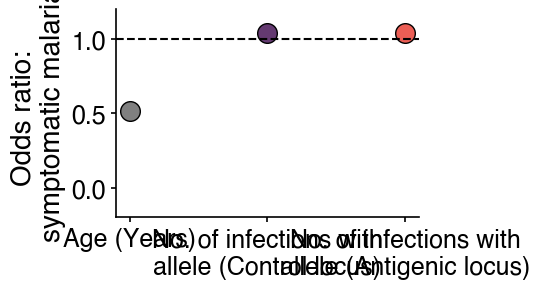

In [236]:
plot_regression(result,['ageYr','lociType[ctrl]:nAllele','lociType[test]:nAllele'],['Age (Years)','No. of infections with\nallele (Control locus)','No. of infections with\nallele (Antigenic locus)'],['grey','#643A71','#EB5E55'], 'figs/symp_nModel.pdf')

In [237]:
merged['timeSinceAlleleMo'] = merged['timeSinceAllele']/30

In [238]:
formula = 'symptomatic ~ lociType:timeSinceAlleleMo + ageYr'
model = smf.glm(formula = formula, data=merged, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            symptomatic   No. Observations:                29578
Model:                            GLM   Df Residuals:                    29574
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10855.
Date:                Sun, 19 Nov 2023   Deviance:                       21711.
Time:                        18:31:24   Pearson chi2:                 3.76e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1686
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

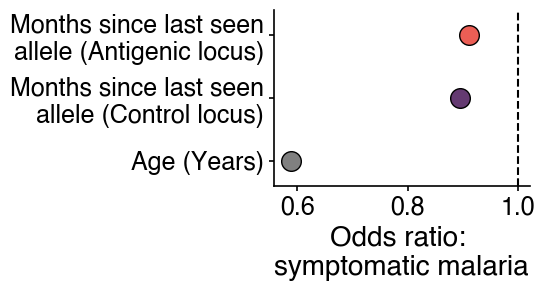

In [240]:
plot_regression(result,['ageYr','lociType[ctrl]:timeSinceAlleleMo','lociType[test]:timeSinceAlleleMo'],['Age (Years)','Months since last seen\nallele (Control locus)','Months since last seen\nallele (Antigenic locus)'],['grey','#643A71','#EB5E55'],'figs/symp_timeModel.pdf')

In [69]:
clones.head()

,person,clone,lociType,pdens,relativeFreq,age,timeSinceAllele,nAllele,logPdens,SeenBefore,deltaPdens,deltaFreq
0,0,1,test,19875.165608,0.988690,15,15,0,4.298311,0,NaN,NaN
1,0,6,test,227.168263,0.011300,15,15,0,2.356348,0,NaN,NaN
2,0,4,ctrl,19875.165608,0.988690,15,15,0,4.298311,0,NaN,NaN
3,0,9,ctrl,227.168263,0.011300,15,15,0,2.356348,0,NaN,NaN
4,0,7,test,14889.113547,0.776923,49,49,0,4.172869,0,NaN,NaN


In [70]:
formula = 'relativeFreq ~ lociType:nAllele'
model = BetaModel.from_formula(formula, clones[(clones.relativeFreq!=1)&(clones.relativeFreq!=0)])
result = model.fit()
print(result.summary())

AssertionError: 

In [66]:
clones.relativeFreq

0        0.988690
1        0.011300
2        0.988690
3        0.011300
4        0.776923
           ...   
29573    0.008005
29574    0.989474
29575    0.991147
29576    0.008423
29577    0.991496
Name: relativeFreq, Length: 29578, dtype: float64

In [63]:
formula = 'relativeFreq ~ lociType:timeSinceAllele'
model = BetaModel.from_formula(formula, clones[(clones.relativeFreq!=1)&(clones.timeSinceAllele.notnull())])
result = model.fit()
print(result.summary())

AssertionError: 

In [551]:
formula = 'relativeFreq ~ lociType:timeSinceAllele'
model = BetaModel.from_formula(formula, clones[(clones.relativeFreq<1)])
result = model.fit()
print(result.summary())

                              BetaModel Results                               
Dep. Variable:           relativeFreq   Log-Likelihood:                 17009.
Model:                      BetaModel   AIC:                        -3.401e+04
Method:            Maximum Likelihood   BIC:                        -3.398e+04
Date:                Sun, 19 Nov 2023                                         
Time:                        22:31:44                                         
No. Observations:               29557                                         
Df Residuals:                   29553                                         
Df Model:                           3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6983      0.010    -69.532      0.000      -0.718     

In [567]:
formula = 'deltaPdens ~ lociType:nAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14807
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          2.4960
Method:                          IRLS   Log-Likelihood:                -27788.
Date:                Tue, 14 Nov 2023   Deviance:                       36958.
Time:                        20:55:51   Pearson chi2:                 3.70e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01054
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [501]:
formula = 'relativeFreq ~ lociType:nAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           relativeFreq   No. Observations:                16295
Model:                            GLM   Df Residuals:                    16292
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.12101
Method:                          IRLS   Log-Likelihood:                -5913.8
Date:                Tue, 14 Nov 2023   Deviance:                       1971.5
Time:                        19:55:18   Pearson chi2:                 1.97e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02544
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [570]:
formula = 'deltaFreq ~ lociType:nAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              deltaFreq   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.17882
Method:                          IRLS   Log-Likelihood:                -8266.9
Date:                Tue, 14 Nov 2023   Deviance:                       2648.0
Time:                        20:59:30   Pearson chi2:                 2.65e+03
No. Iterations:                     3   Pseudo R-squ. (CS):           0.003839
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [494]:
formula = 'logPdens ~ lociType:timeSinceAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               logPdens   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.8788
Method:                          IRLS   Log-Likelihood:                -25685.
Date:                Tue, 14 Nov 2023   Deviance:                       27822.
Time:                        19:51:59   Pearson chi2:                 2.78e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1206
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [568]:
formula = 'deltaPdens ~ lociType:timeSinceAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             deltaPdens   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          2.4834
Method:                          IRLS   Log-Likelihood:                -27751.
Date:                Tue, 14 Nov 2023   Deviance:                       36774.
Time:                        20:56:24   Pearson chi2:                 3.68e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01552
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [502]:
formula = 'relativeFreq ~ lociType:timeSinceAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           relativeFreq   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.11174
Method:                          IRLS   Log-Likelihood:                -4785.0
Date:                Tue, 14 Nov 2023   Deviance:                       1654.7
Time:                        19:56:38   Pearson chi2:                 1.65e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02923
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [574]:
formula = 'deltaFreq ~ lociType:timeSinceAllele'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              deltaFreq   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.17862
Method:                          IRLS   Log-Likelihood:                -8258.6
Date:                Tue, 14 Nov 2023   Deviance:                       2645.1
Time:                        21:00:24   Pearson chi2:                 2.65e+03
No. Iterations:                     3   Pseudo R-squ. (CS):           0.004956
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [580]:
infections.columns

Index(['person', 'pdens', 'symptomatic', 'infectNumber', 'COIinfection',
       'clonesBefore', 'malariaNumber', 'age', 'timeSince', 'timeSinceSymp',
       'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen',
       'propCtrlSeen', 'propTestPop', 'propCtrlPop', 'logPdens', 'TestBefore',
       'CtrlBefore', 'deltaPdens'],
      dtype='object')

In [ ]:
For clones, relative frequency by number of Alleles is significant.

In [657]:
formula = 'timeSinceSymp ~  nTest + nCtrl + age + clonesBefore + infectNumber'
model = smf.glm(formula = formula, data=infections[infections.symptomatic==1], family=sm.families.Gamma(link=sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          timeSinceSymp   No. Observations:                  943
Model:                            GLM   Df Residuals:                      937
Model Family:                   Gamma   Df Model:                            5
Link Function:               identity   Scale:                         0.24709
Method:                          IRLS   Log-Likelihood:                -4932.2
Date:                Tue, 14 Nov 2023   Deviance:                       226.87
Time:                        22:07:46   Pearson chi2:                     232.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.8752
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       49.9534      2.799     17.845   

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [662]:
formula = 'timeSinceSymp ~  timeSinceTest + timeSinceCtrl + timeSince'
model = smf.glm(formula = formula, data=infections[infections.symptomatic==1], family=sm.families.Gamma(link=sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          timeSinceSymp   No. Observations:                  762
Model:                            GLM   Df Residuals:                      758
Model Family:                   Gamma   Df Model:                            3
Link Function:               identity   Scale:                         0.36292
Method:                          IRLS   Log-Likelihood:                -4253.9
Date:                Tue, 14 Nov 2023   Deviance:                       238.78
Time:                        22:08:53   Pearson chi2:                     275.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6026
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        24.5664      4.987      4.926

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [616]:
formula = 'timeSinceSymp ~ clonesBefore + infectNumber + age + TestBefore + CtrlBefore'
model = smf.glm(formula = formula, data=infections[infections.symptomatic==1], family=sm.families.Gamma(link=sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          timeSinceSymp   No. Observations:                  943
Model:                            GLM   Df Residuals:                      937
Model Family:                   Gamma   Df Model:                            5
Link Function:               identity   Scale:                         0.24254
Method:                          IRLS   Log-Likelihood:                -4915.8
Date:                Tue, 14 Nov 2023   Deviance:                       219.15
Time:                        21:30:31   Pearson chi2:                     227.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.8839
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.8229      2.622     19.767   

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [618]:
formula = 'timeSinceSymp ~ clonesBefore + age + propTestSeen + propCtrlSeen'
model = smf.glm(formula = formula, data=infections[infections.symptomatic==1], family=sm.families.Gamma(link=sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          timeSinceSymp   No. Observations:                  943
Model:                            GLM   Df Residuals:                      940
Model Family:                   Gamma   Df Model:                            2
Link Function:               identity   Scale:                         0.82275
Method:                          IRLS   Log-Likelihood:                -5376.1
Date:                Tue, 14 Nov 2023   Deviance:                       480.19
Time:                        22:09:12   Pearson chi2:                     773.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.2580
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       30.3400      3.507      8.651   

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


(array([664., 158.,  58.,  28.,  12.,   5.,   9.,   1.,   4.,   4.]),
 array([  23. ,  133.6,  244.2,  354.8,  465.4,  576. ,  686.6,  797.2,
         907.8, 1018.4, 1129. ]),
 <BarContainer object of 10 artists>)

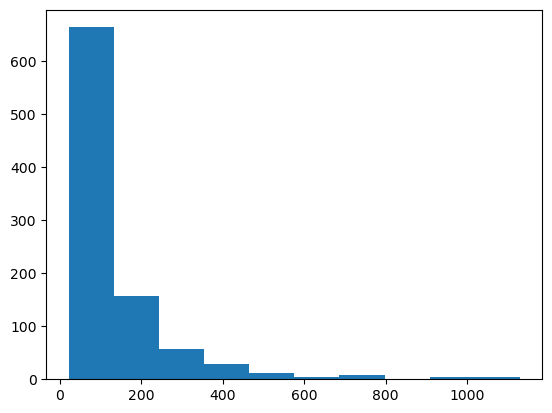

In [587]:
fig,ax = plt.subplots()
ax.hist(infections[infections.symptomatic==1]['timeSinceSymp'])

In [592]:
sm.families.family.Gamma.links

[statsmodels.genmod.families.links.Log,
 statsmodels.genmod.families.links.identity,
 statsmodels.genmod.families.links.inverse_power]

In [ ]:
sm.families.family.Gaussian.links

[statsmodels.genmod.families.links.Log,
 statsmodels.genmod.families.links.identity,
 statsmodels.genmod.families.links.inverse_power]

In [677]:
sm.families.family.Binomial.links

[statsmodels.genmod.families.links.Logit,
 statsmodels.genmod.families.links.probit,
 statsmodels.genmod.families.links.cauchy,
 statsmodels.genmod.families.links.Log,
 statsmodels.genmod.families.links.CLogLog,
 statsmodels.genmod.families.links.LogLog,
 statsmodels.genmod.families.links.identity]

In [666]:
formula = 'timeSinceSymp ~ age + propTestPop + propCtrlPop'
model = smf.glm(formula = formula, data=infections[infections.symptomatic==1], family=sm.families.Gamma(link=sm.families.links.identity()))
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          timeSinceSymp   No. Observations:                  943
Model:                            GLM   Df Residuals:                      939
Model Family:                   Gamma   Df Model:                            3
Link Function:               identity   Scale:                         0.32307
Method:                          IRLS   Log-Likelihood:                -5013.8
Date:                Tue, 14 Nov 2023   Deviance:                       263.84
Time:                        22:09:45   Pearson chi2:                     303.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.7701
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.6344      2.890      7.486      

/Users/cwagner2/miniconda3/envs/antigens/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


So, for infections, only logPdens ~ propAllelePop, or for clones, relativeFreq ~ timeSinceAllele (in beta regression)

Concluded that things don't really work all that well. infectNumber & clonesBefore are all significant tho..

Alternative approaches:
- time until allele seen
- haplotype diversity
- first to second, change in parasite density

In [742]:
#clones['nInfections']=clones.groupby(['lociType']).apply('size')
clones['nInfections'] = clones.groupby(['lociType'])['lociType'].transform('size')
clones['nClones'] = clones.groupby(['lociType','clone'])['clone'].transform('size')
clones['popFreq'] = clones['nClones']/clones['nInfections']
clones['rate'] = 1/clones['timeSinceAllele']

In [728]:
clones.rate

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
16290    0.000624
16291    0.001269
16292    0.000624
16293    0.000595
16294    0.000624
Name: rate, Length: 16295, dtype: float64

In [735]:
formula = 'rate ~ popFreq + lociType'
model = smf.glm(formula = formula, data=clones, family=sm.families.Gaussian())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   rate   No. Observations:                14811
Model:                            GLM   Df Residuals:                    14808
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      0.00010014
Method:                          IRLS   Log-Likelihood:                 47182.
Date:                Wed, 15 Nov 2023   Deviance:                       1.4829
Time:                        10:11:34   Pearson chi2:                     1.48
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0009312
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0029      0.000  

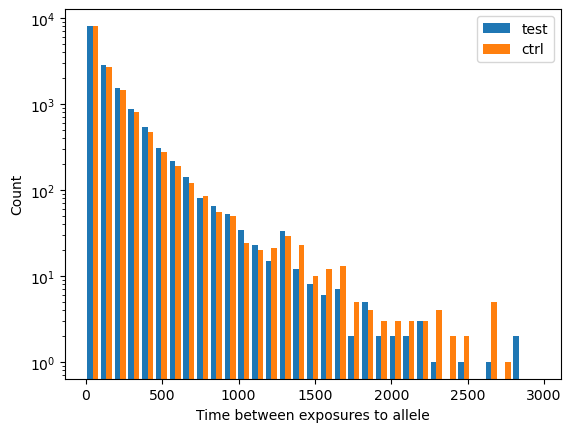

In [262]:
fig, ax = plt.subplots()

data = [clones[clones.lociType==loc]['timeSinceAllele'] for loc in ['test','ctrl']]
ax.hist(data, label=['test','ctrl'],log=True,bins=np.arange(0,3000,90))
ax.legend()
ax.set_xlabel('Time between exposures to allele')
ax.set_ylabel('Count')
plt.show()

In [248]:
infections.columns

Index(['person', 'pdens', 'symptomatic', 'infectNumber', 'COIinfection',
       'clonesBefore', 'malariaNumber', 'age', 'timeSince', 'timeSinceSymp',
       'timeSinceTest', 'timeSinceCtrl', 'nTest', 'nCtrl', 'propTestSeen',
       'propCtrlSeen', 'propTestPop', 'propCtrlPop', 'logPdens', 'TestBefore',
       'CtrlBefore', 'deltaPdens'],
      dtype='object')

In [ ]:
## Do the Bryan thing. Figure out how to run sims at range of EIRs and then test all models.
## permutation test